<a href="https://colab.research.google.com/github/Jittiphat-s/Project-Antibiogram/blob/main/Antibiogram_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STEP 1 : IMPORT & LOAD DATA

##Step1.1ติดตั้งไลบารี่

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

!pip install openpyxl
!pip install rapidfuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 20.7 MB/s eta 0:00:00


##Step1.2 โหลดไลบรารี + ตั้งค่า BASE / encoding

โหลดไลบรารีที่ใช้ (re/numpy/pandas/openpyxl), ตั้งค่า BASE และ encoding (ENC_IPD_DATA, ENC_CULTURE) และเตรียมฟังก์ชัน normalize_columns() เพื่อทำให้ชื่อคอลัมน์เป็นตัวพิมพ์เล็กและตัดช่องว่าง

In [ ]:
import re                                  # เรียกความสามารถจัดการตัวหนังสือแบบมีแบบแผน เช่น เอาตัวอักษรในวงเล็บออก
import numpy as np                         # เรียกความสามารถคำนวณจำนวนและค่าที่ว่าง
import pandas as pd                        # เรียกความสามารถจัดการตารางข้อมูล
from openpyxl import Workbook              # เรียกความสามารถสร้างไฟล์ตารางแบบเปิดในโปรแกรมตารางได้
from openpyxl.styles import PatternFill, Alignment  # เรียกความสามารถเติมสีพื้นหลังและจัดการวางข้อความในตาราง
from openpyxl.utils.dataframe import dataframe_to_rows  # เรียกความสามารถแปลงตารางให้กลายเป็นแถวสำหรับเขียนลงไฟล์

BASE = "/content/drive/MyDrive/Colab Notebooks/File Colab"  # ระบุโฟลเดอร์ที่วางไฟล์ข้อมูลของเรา
ENC_IPD_DATA = "utf-8-sig"                 # ระบุรูปแบบตัวหนังสือสำหรับไฟล์ข้อมูลผู้ป่วย (อ่านภาษาไทยได้ดี)
ENC_CULTURE  = "iso8859_11"                # ระบุรูปแบบตัวหนังสือสำหรับไฟล์ผลเพาะเชื้อที่เป็นของเก่า (อ่านไทยเก่าได้)

def normalize_columns(df):
    df.columns = df.columns.str.lower().str.strip()
    return df

##Step1.3 อ่านไฟล์ IPD_Data, IPD_Cul, OPD_Cul

* อ่าน IPD_Data.txt ด้วยตัวคั่นแท็บ (sep="\t") และ encoding=ENC_IPD_DATA จากนั้น normalize ชื่อคอลัมน์ และคัดเฉพาะคอลัมน์สำคัญไว้สำหรับ enrich (เช่น เพศ อายุ vn/an/วันที่)

* อ่าน IPD_Cul02.txt (หรือชื่อไฟล์ที่ใช้งานจริง) ด้วย encoding=ENC_CULTURE, ปรับชื่อคอลัมน์ และคัดคอลัมน์ที่จำเป็นในการวิเคราะห์ เช่น (hn/an/vn, org, anti/anti_name, anti_result, anti_mic, date_r, time_r, lst/rep เป็นต้น)

* อ่านไฟล์ OPD culture และปรับชื่อคอลัมน์ให้สอดคล้องกับ IPD (รวมถึง vn) เพื่อเตรียมรวมเป็นฐานเดียวกัน

In [ ]:
def _read_ipd_data(path, enc):
    try:
        df = pd.read_csv(path, sep=",", encoding=enc, low_memory=False)
        if df.shape[1] == 1:
            df = pd.read_csv(path, sep="\t", encoding=enc, low_memory=False)
    except Exception:
        df = pd.read_csv(path, sep="\t", encoding=enc, low_memory=False)
    df = normalize_columns(df)

    # Cleaning เบื้องต้น
    if 'sex' in df.columns:
        df['sex'] = df['sex'].str.strip().replace({'ชาย':'Male','หญิง':'Female'})
    if 'age' in df.columns:
        df['age'] = pd.to_numeric(df['age'], errors='coerce')
    return df

def _read_culture(path, enc):
    try:
        df = pd.read_csv(path, sep=",", encoding=enc, low_memory=False)
        if df.shape[1] == 1:
            df = pd.read_csv(path, sep="\t", encoding=enc, low_memory=False)
    except Exception:
        df = pd.read_csv(path, sep="\t", encoding=enc, low_memory=False)
    df = normalize_columns(df)

    # ✅ Cleaning เบื้องต้น
    if 'anti_result' in df.columns:
        df['anti_result'] = (
            df['anti_result']
            .astype(str).str.strip().str.upper()
            .replace({
                'NAN': np.nan,   # ตัวใหญ่
                'nan': np.nan,   # ตัวเล็ก
                'NONE': np.nan,  # คำว่า None
                '': np.nan       # ช่องว่าง
            })
        )
    if 'date_r' in df.columns:
        df['date_r'] = pd.to_datetime(df['date_r'], errors='coerce')
    if 'time_r' in df.columns:
        s = df['time_r'].astype(str).str.strip()
        df['time_r'] = pd.to_datetime(s, errors='coerce').dt.strftime('%H:%M:%S')
    return df


# อ่านและ clean แยก
df_ipd_data = _read_ipd_data(f"{BASE}/IPD_Data.txt", ENC_IPD_DATA)
df_ipd_cul  = _read_culture(f"{BASE}/IPD_Cul02.txt", ENC_CULTURE)
df_opd_cul  = _read_culture(f"{BASE}/OPD_Cul.txt", ENC_CULTURE)


/tmp/ipython-input-3394319377.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time_r'] = pd.to_datetime(s, errors='coerce').dt.strftime('%H:%M:%S')
/tmp/ipython-input-3394319377.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time_r'] = pd.to_datetime(s, errors='coerce').dt.strftime('%H:%M:%S')


In [ ]:
cols_ipd_data = [                         # บอกว่าจากข้อมูลผู้ป่วย เราต้องการคอลัมน์ไหนบ้าง
    'vn','an','hn','sex','age','nat_code','nat','ward_admit_code','ward_dc_code','spc_code'
]

cols_ipd_cul = [                          # บอกว่าจากผลเพาะเชื้อ (ผู้ป่วยใน) เราต้องการคอลัมน์ไหนบ้าง
    'an','barcode','code','specimen','mb_code','org','dia','anti','anti_name','anti_result','anti_mic','date_r','time_r','lst','rep'
]

cols_opd_cul = [                          # บอกว่าจากผลเพาะเชื้อ (ผู้ป่วยนอก) เราต้องการคอลัมน์ไหนบ้าง
    'vn','barcode','code','specimen','mb_code','org','dia','anti','anti_name','anti_result','anti_mic','date_r','time_r','lst','rep'
]

df_ipd_data_use = df_ipd_data[[c for c in cols_ipd_data if c in df_ipd_data.columns]].copy()  # เลือกเฉพาะคอลัมน์ที่มีอยู่จริงจากข้อมูลผู้ป่วย
df_cul_ipd      = df_ipd_cul[[c for c in cols_ipd_cul if c in df_ipd_cul.columns]].copy()  # เลือกเฉพาะคอลัมน์ที่มีอยู่จริงจากผลเพาะเชื้อผู้ป่วยใน
df_cul_opd      = df_opd_cul[[c for c in cols_opd_cul if c in df_opd_cul.columns]].copy()    # เลือกเฉพาะคอลัมน์ที่มีอยู่จริงจากผลเพาะเชื้อผู้ป่วยนอก

df_all = pd.concat([df_cul_ipd, df_cul_opd], ignore_index=True)        # นำผลเพาะเชื้อจากในและนอกมารวมเป็นตารางเดียวกัน
for c in df_all.columns:                                               # เดินดูทีละคอลัมน์ในตารางรวม
    if df_all[c].dtype == object:                                      # ถ้าเป็นชนิดตัวหนังสือ
        s = df_all[c].astype(str).str.strip()                          # แปลงเป็นตัวหนังสือและตัดช่องว่างหัวท้าย
        s = s.replace({'nan': np.nan, 'None': np.nan, '': np.nan})     # แทนคำที่เหมือนว่างให้เป็นค่าว่างจริง
        df_all[c] = s                                                  # ใส่กลับคืน

#STEP 2 : COLUMN CHECK & STRUCTURE VALIDATION

In [ ]:
# STEP 2.0 : Settings & Helper (no data changes)
import re
import pandas as pd

# คอลัมน์ขั้นต่ำที่ต้องมีในชุดเพาะเชื้อ (ตามสเปกเรา)
REQUIRED_CULTURE_COLS = ["Specimen", "Org", "Anti_name", "Anti_result"]

def check_presence_case_insensitive(df: pd.DataFrame, required_cols):
    """
    คืนรายงานว่าคอลัมน์ที่ต้องการ 'มี/ไม่มี' (เทียบแบบไม่สนตัวพิมพ์) — ไม่แก้ไข df
    return: dict { total_cols, found:[ชื่อจริงในตาราง], missing:[ชื่อที่ควรมีแต่ไม่พบ] }
    """
    cols_lower = {c.lower(): c for c in df.columns}
    found, missing = [], []
    for need in required_cols:
        hit = cols_lower.get(need.lower())
        if hit is not None:
            found.append(hit)      # ชื่อจริงที่พบ
        else:
            missing.append(need)   # ชื่อที่ควรมีแต่ไม่พบ
    return {
        "total_cols": len(df.columns),
        "found": found,
        "missing": missing
    }


##STEP 2.1 : ตรวจคอลัมน์ของ IPD_Data

In [ ]:
# แสดงรายชื่อคอลัมน์ทั้งหมดของ IPD_Data (ไม่แตะข้อมูล)
print("# IPD_Data columns:")
print(list(df_ipd_data.columns))

# ช่วยเน้นคอลัมน์ที่ 'น่าจะใช้ต่อ' เฉย ๆ (ยังไม่ใช่การ normalize)
_IPD_INTEREST_PATTERNS = [r"\bhn\b", r"\ban\b", r"\bvn\b", r"ward", r"sex|gender", r"age", r"date|time|admit"]
ipd_hits = [c for c in df_ipd_data.columns if any(re.search(p, c, flags=re.I) for p in _IPD_INTEREST_PATTERNS)]
print("# IPD_Data likely-useful columns (preview):")
print(ipd_hits)


# IPD_Data columns:
['vn', 'an', 'hn', 'sex', 'age', 'nat_code', 'nat', 'rights_used_code', 'rights_used', 'rights_main_code', 'rights_main', 'ward_admit_code', 'ward_dc_code', 'spc_code', 'spc', 'comefor_code', 'comefor', 'pt_new', 'hmain_code', 'hmain', 'dischs_code', 'dischs', 'discht_code', 'discht', 'dc_date', 'dc_time', 'adm_date', 'adm_time', 'los_day', 'los_hours']
# IPD_Data likely-useful columns (preview):
['vn', 'an', 'hn', 'sex', 'age', 'ward_admit_code', 'ward_dc_code', 'dc_date', 'dc_time', 'adm_date', 'adm_time']


##STEP 2.2 : ตรวจคอลัมน์ของ IPD_Cul / OPD_Cul

In [ ]:
presence_opd = check_presence_case_insensitive(df_opd_cul, REQUIRED_CULTURE_COLS)
presence_ipd = check_presence_case_insensitive(df_ipd_cul, REQUIRED_CULTURE_COLS)

print("# OPD_Cul presence:", presence_opd)
print("# IPD_Cul presence:", presence_ipd)


# OPD_Cul presence: {'total_cols': 15, 'found': ['specimen', 'org', 'anti_name', 'anti_result'], 'missing': []}
# IPD_Cul presence: {'total_cols': 16, 'found': ['specimen', 'org', 'anti_name', 'anti_result'], 'missing': []}


##STEP 2.3 : สรุปผลรวมเป็น COL_PRESENCE_REPORT

In [ ]:
# STEP 2.3 : Summary object — เก็บไว้ใช้อ้างอิงขั้นต่อไป
COL_PRESENCE_REPORT = {
    "REQUIRED_CULTURE_COLS": REQUIRED_CULTURE_COLS,
    "OPD_Cul": presence_opd,
    "IPD_Cul": presence_ipd,
}
COL_PRESENCE_REPORT


{'REQUIRED_CULTURE_COLS': ['Specimen', 'Org', 'Anti_name', 'Anti_result'],
 'OPD_Cul': {'total_cols': 15,
  'found': ['specimen', 'org', 'anti_name', 'anti_result'],
  'missing': []},
 'IPD_Cul': {'total_cols': 16,
  'found': ['specimen', 'org', 'anti_name', 'anti_result'],
  'missing': []}}

#STEP 3 : Regular expression (cleaning) CLEANING PIPELINE (ORGANISM + SPECIMEN)

###INITIALIZE HELPERS

In [ ]:
# ===================== STEP 3 : INITIALIZE HELPERS (RAPIDFUZZ CLEAN VERSION) =====================

import re
import numpy as np
from rapidfuzz import fuzz, process   # ← ใช้ rapidfuzz

# --------------------------------------------------------------
# 1) clean_token — ใช้ทุกจุดใน STEP 3.2
# --------------------------------------------------------------
def clean_token(x: str) -> str:
    """
    Normalize organism strings:
    - lowercase
    - strip spaces
    - collapse multiple spaces
    - remove trailing periods
    """
    if not isinstance(x, str):
        return ""
    s = x.strip().lower()
    s = re.sub(r"\s+", " ", s)
    s = s.rstrip(".")
    return s


# --------------------------------------------------------------
# 2) harmonize_standard — normalize canonical names
# --------------------------------------------------------------
def harmonize_standard(x: str) -> str:
    """
    Convert cleaned organism names into consistent title-case canonical form.
    """
    if not isinstance(x, str):
        return x
    s = clean_token(x)
    if " spp" in s:
        return s.replace(" spp", " spp.").title()
    return s.title()


# --------------------------------------------------------------
# 3) is_noise_org — ใช้เฉพาะ noise จริง ๆ (ไม่ชน canonical)
# --------------------------------------------------------------
def is_noise_org(x: str) -> bool:
    """
    Return True if organism is clearly noise/contaminant.
    Avoid terms that overlap with canonical groups.
    """
    if not isinstance(x, str):
        return True
    s = clean_token(x)

    noise_terms = [
        "yeast",
        "fungus",
        "fungi",
        "mold",
        "mixed flora",
        "unidentified",
        "diphtheroid",
        "skin flora",
        "environmental",
        "contaminant",
    ]

    return any(term in s for term in noise_terms)

SPECIMEN_MAP = {
    # Blood sources
    "femoral dlc": "Blood",
    "lt femeral dlc": "Blood",
    "rt femeral dlc": "Blood",
    "jugular vein": "Blood",
    "from jugular vein": "Blood",
    "peripheral vein": "Blood",
    "picc": "Blood",
    "pv1": "Blood",
    "pv2": "Blood",

    # Urine sources
    "rt pcn": "Urine",
    "lt pcn": "Urine",
    "pcn": "Urine",
    "foley cath": "Urine",
    "foley's cath": "Urine",
    "folet": "Urine",
    "nephrostomy": "Urine",
    "nephrost": "Urine",
    "pouch": "Urine",  # ถ้าต้องการให้เป็น Wound บอกได้

    # Pus / wound / tissue
    "pus": "Pus",
    "pus from": "Pus",
    "pus from rt.ear": "Pus",
    "pus from peg stoma": "Pus",
    "pressure sore": "Wound",
    "bed sore": "Wound",
    "pressure sore rt buttock": "Wound",
    "tissue from pressure sore": "Tissue",
    "rt toe": "Wound",
    "lt drain": "Drain Fluid",
    "drain": "Drain Fluid",
    "rt drain": "Drain Fluid",
    "submand area": "Pus",
    "coloplast": "Wound",

    # Eye
    "from eye": "Eye Discharge",
    "discharge rt eye": "Eye Discharge",

    # Bile
    "ptbd": "Bile",

    # Genital
    "penis": "Genital Swab",

    # Default fallback
    "stoma": "Wound",
}



##STEP 3.1 : Cleaning IPD_Data

###STEP 3.1.1 : Cleaning IPD_Data

In [ ]:
# ===================== STEP 3.1 : Cleaning IPD_Data =====================
def clean_ipd_data(df_ipd_data: pd.DataFrame) -> pd.DataFrame:
    df = df_ipd_data.copy()

    # sex → normalize
    if 'sex' in df.columns:
        df['sex'] = df['sex'].astype(str).str.strip().replace({
            'ชาย': 'Male',
            'หญิง': 'Female'
        })

    # age → numeric 1–120
    if 'age' in df.columns:
        df['age'] = pd.to_numeric(df['age'], errors='coerce')
        df.loc[(df['age'] < 1) | (df['age'] > 120), 'age'] = np.nan

    # nationality code/name → strip spaces
    for col in ['nat_code', 'nat']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().replace({'nan': np.nan, '': np.nan})

    # ward codes → strip spaces
    for col in ['ward_admit_code', 'ward_dc_code']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()

    return df

# เรียกใช้ฟังก์ชันเพื่อสร้าง DataFrame ที่ clean แล้ว
df_ipd_data_clean = clean_ipd_data(df_ipd_data_use)

###STEP 3.1.2 : clean_specimen_raw()

In [ ]:
def clean_specimen_raw(x):
    if not isinstance(x, str):
        return None

    s = x.strip()

    # remove encoding noise เช่น เธ
    s = re.sub(r"[^\x00-\x7F]+", " ", s)

    # remove parentheses content
    s = re.sub(r"\(.*?\)", "", s)

    # collapse spaces
    s = re.sub(r"\s+", " ", s)

    return s.strip()


###STEP 3.1.3 : extract specimen จาก comment

In [ ]:
def extract_specimen_from_comment(text):
    if not isinstance(text, str):
        return None
    match = re.search(r"@Lab Comment:\s*([A-Za-z0-9\- ]+)", text)
    if match:
        value = match.group(1).strip().lower()
        if value and value != "-" and len(value) > 2:
            return value
    return None


###STEP 3.1.4 : SPECIMEN_MAP

In [ ]:
SPECIMEN_MAP = {
    "pus": "Pus",
    "urine": "Urine",
    "blood": "Blood",
    "sputum": "Sputum",
    "bile": "Bile",
    "stool": "Stool",
    "tissue": "Tissue",
    "wound": "Wound",
    "genital": "Genital",
    "genital swab": "Genital Swab",
    "drain fluid": "Drain Fluid",
    "eye discharge": "Eye Discharge",
    "catheter tip": "Catheter Tip",
    "capd": "CAPD",
    "exit site": "Exit Site",
    "pleural fluid": "Pleural Fluid",
    "ascitic fluid": "Ascitic Fluid",
    "et secretion": "ET Secretion",
    "bal": "BAL",
    "peg": "PEG",
    "jejunostomy": "Jejunostomy",
    "conduit": "Conduit",

    # Catheter / Line
    "central line": "Catheter Tip",
    "c-line": "Catheter Tip",
    "cvc": "Catheter Tip",
    "hickman": "Catheter Tip",
    "foley": "Catheter Tip",
    "spc": "Catheter Tip",
    "cath": "Catheter Tip",
    "single cath": "Catheter Tip",
    "c line": "Catheter Tip",
    "a-line": "Catheter Tip",
    "a line": "Catheter Tip",
    "3-lumen": "Catheter Tip",
    "triple lumen": "Catheter Tip",
    "h/c": "Catheter Tip",

    # Drain / PCN / PTBD
    "drain": "Drain Fluid",
    "drain 2": "Drain Fluid",
    "pcn": "Urine",
    "rt pcn": "Urine",
    "lt pcn": "Urine",
    "ptbd": "Bile",
    "pcd": "Drain Fluid",

    # Wound / Bedsore
    "bed sore": "Wound",
    "bedsore": "Wound",
    "pressure sore": "Wound",
    "rt leg": "Wound",
    "rt foot": "Wound",
    "anus": "Wound",
    "lt leg": "Wound",
    "rt icd": "Wound",
    "lt neck": "Wound",
    "rt ear": "Wound",
    "lt eye": "Wound",
    "stump": "Wound",
    "perianal": "Wound",
    "lt. arm": "Wound",
    "right groin": "Wound",
    "left knee": "Wound",
    "tumor": "Wound",
    "coccyx": "Wound",
    "rt": "Wound",
    "lt": "Wound",

    # Genital
    "penis": "Genital",
    "from penis": "Genital",
    "from vagina": "Genital",
    "pennis": "Genital",
    "vulva": "Genital",

    # Respiratory / Discharge
    "tracheostomy": "Respiratory Secretion",
    "discharge": "Eye Discharge",

    # Blood / Urine / Fluid
    "peripheral": "Blood",
    "pv1": "Blood",
    "pv2": "Blood",
    "pv": "Blood",
    "bottle1#": "Blood",
    "bottle2#": "Blood",

    "void": "Urine",
    "cystostomy": "Urine",
    "cystos": "Urine",
    "stone from rt. kidney": "Urine",
    "stone from lt. kidney": "Urine",

    "abdominal fluid": "Fluid",
    "fluid from intraabdominal collection": "Fluid",
    "fluid from ascites": "Fluid",

    # Wound / Discharge
    "lesion": "Wound",
    "peristomal skin": "Wound",
    "anal abscess": "Wound",
    "rt arm": "Wound",
    "trunk": "Wound",
    "rt eye": "Eye Discharge",
    "lt ear": "Ear Discharge",

    # Drain
    "t tube": "Drain",

    "abdomen": "Wound",
    "fluid from ascites": "Ascitic Fluid",
    "dialysate": "Dialysate",
    "vagina": "Genital",
    "ulcer at bottom": "Wound",

    "abdominal fluid": "Fluid",
    "urethra": "Genital",
    "oral": "Oral",
    "tt tube": "Drain",


}


###STEP 3.1.5 : normalize_specimen()

In [ ]:
def normalize_specimen(x):
    if not isinstance(x, str):
        return None

    s = x.strip().lower()

    # ✅ ตัด prefix @Lab Comment:- ออก
    s = re.sub(r"^@?\s*lab comment[:-]\s*", "", s).strip()

    # remove numeric-only values เช่น 1, 2, 14.20
    if re.match(r"^\d+(\.\d+)?$", s):
        return None

    # remove words that are not specimen
    if s in ["from", "day1", "day2", "lt", "rt", "al", "sen", "cl"]:
        return None

    # map exact match
    if s in SPECIMEN_MAP:
        return SPECIMEN_MAP[s]

    # fuzzy match (ใช้ regex match คำเต็ม)
    for k in SPECIMEN_MAP:
        if re.search(r"\b" + re.escape(k) + r"\b", s):
            return SPECIMEN_MAP[k]

    return None


##STEP 3.2 : CLEANING CULTURE DATA (IPD_Cul + OPD_Cul)

###STEP 3.2.1: normalize_base = base cleaning (manual map + canonical regex + genus‑aware fuzzy + global fuzzy). ไม่แตะ spp. rule และ isolate logic

####STEP 3.2.1.1

In [ ]:

def clean_org_raw(x):
    if not isinstance(x, str):
        return np.nan
    s = x.strip()

    # remove parentheses content
    s = re.sub(r"\(.*?\)", "", s)

    # remove resistance tags
    s = re.sub(r"(ESBL|CRE|MRSA|VRE|MDR|XDR)", "", s, flags=re.I)

    # collapse spaces
    s = re.sub(r"\s+", " ", s)

    return s.strip()



MAP_TO_STANDARD = {


      # ============================
    # Acinetobacter → Baumannii Complex
    # ============================
    "acinetobacter pittii": "Acinetobacter Baumannii Complex",
    "acinetobacter junii": "Acinetobacter Baumannii Complex",
    "acinetobacter lwoffii": "Acinetobacter Baumannii Complex",
    "acinetobacter nosocomialis": "Acinetobacter Baumannii Complex",
    "acinetobacter radioresistens": "Acinetobacter Baumannii Complex",
    "acinetobacter schindleri": "Acinetobacter Baumannii Complex",
    "acinetobacter seifertii": "Acinetobacter Baumannii Complex",
    "acinetobacter ursingii": "Acinetobacter Baumannii Complex",
    "acinetobacter haemolyticus": "Acinetobacter Baumannii Complex",
    "acinetobacter baumannii": "Acinetobacter Baumannii Complex",
    "acb complex": "Acinetobacter Baumannii Complex",
    "a baumannii": "Acinetobacter Baumannii Complex",
    "a. baumannii": "Acinetobacter Baumannii Complex",

    # Misspellings / OCR
    "acinetob": "Acinetobacter Baumannii Complex",
    "acine": "Acinetobacter Baumannii Complex",
    "acinet": "Acinetobacter Baumannii Complex",
    "acinetobacte": "Acinetobacter Baumannii Complex",
    "acinetobac": "Acinetobacter Baumannii Complex",
    "acinetobacter bau++++++++++mannii": "Acinetobacter Baumannii Complex",
    "acinetobacter bauma": "Acinetobacter Baumannii Complex",
    "acinetobacter baum": "Acinetobacter Baumannii Complex",
    "acinetobacter bauma nnii": "Acinetobacter Baumannii Complex",
    "acinetobacter bauman nii": "Acinetobacter Baumannii Complex",
    "acinetobacter bau8511617mannii": "Acinetobacter Baumannii Complex",
    "acinetobacter baum2990794annii": "Acinetobacter Baumannii Complex",

    # ============================
    # Acinetobacter Spp.
    # ============================
    "acinetobacter spp.": "Acinetobacter Spp.",
    "acinetobacter alcaligenes": "Acinetobacter Spp.",
    "acinetobacter johnsonii": "Acinetobacter Spp.",
    # ============================
    # Aeromonas → Aeromonas Hydrophila
    # ============================
    "aeromonas hydrophila": "Aeromonas Hydrophila",
    "aeromonas sobria": "Aeromonas Hydrophila",
    "aeromonas punctata": "Aeromonas Hydrophila",
    "aeromonas schubertii": "Aeromonas Hydrophila",
    "aeromonas caviae": "Aeromonas Hydrophila",
    "aeromonas media": "Aeromonas Hydrophila",
    "aeromonas spp.": "Aeromonas Hydrophila",

    # Misspellings / OCR
    "aeromonas hyd rophila": "Aeromonas Hydrophila",
    "aeromonas hydrophi la": "Aeromonas Hydrophila",
    "aeromonas hydrophil a": "Aeromonas Hydrophila",
    "aeromonas hydrophi": "Aeromonas Hydrophila",
    "aeromonas hyd ro phil a": "Aeromonas Hydrophila",
    # ============================
    # Burkholderia → Cepacia Complex
    # ============================
    "burkholderia cepacia": "Burkholderia Cepacia Complex",
    "burkholderia multivorans": "Burkholderia Cepacia Complex",
    "burkholderia vietnamiensis": "Burkholderia Cepacia Complex",
    "burkholderia cenocepacia": "Burkholderia Cepacia Complex",
    "burkholderia contaminans": "Burkholderia Cepacia Complex",

    # Misspellings / OCR
    "burkholderia cepa cia": "Burkholderia Cepacia Complex",
    "burkholderia cepac ia": "Burkholderia Cepacia Complex",
    "burkholderia cepa": "Burkholderia Cepacia Complex",
    "burkholderia ce pacia": "Burkholderia Cepacia Complex",

    # ============================
    # Burkholderia pseudomallei
    # ============================
    "burkholderia pseudomallei": "Burkholderia Pseudomallei",
    "b. pseudomallei": "Burkholderia Pseudomallei",
    "burkholderia pseudomalei": "Burkholderia Pseudomallei",
    "burkholderia pseudomall ei": "Burkholderia Pseudomallei",
    "burkholderia pseudomallii": "Burkholderia Pseudomallei",
    # ============================
    # Citrobacter → Citrobacter Spp.
    # ============================
    "citrobacter freundii": "Citrobacter Spp.",
    "citrobacter freundii complex": "Citrobacter Spp.",
    "citrobacter koseri": "Citrobacter Spp.",
    "citrobacter amalonaticus": "Citrobacter Spp.",
    "citrobacter werkmannii": "Citrobacter Spp.",
    "citrobacter sedlakii": "Citrobacter Spp.",
    "citrobacter spp.": "Citrobacter Spp.",
    "citrobacter sp": "Citrobacter Spp.",
    "citrobacter species": "Citrobacter Spp.",

    # Newly added from NaN list
    "citrobacter braakii": "Citrobacter Spp.",
    "pseudocitrobacter faecalis": "Citrobacter Spp.",

    # OCR / misspellings
    "citrobacter fruendii": "Citrobacter Spp.",
    "citrobacter freundi": "Citrobacter Spp.",
    "citrobacter freundi": "Citrobacter Spp.",
    "citrobacter freundi+": "Citrobacter Spp.",
    "citrobacter freundii+": "Citrobacter Spp.",
    "citrobacter freundii complex+": "Citrobacter Spp.",
    "citrobacter freundii co": "Citrobacter Spp.",
    "citrobacter freundii co.": "Citrobacter Spp.",
    "citrobacter freundii compl ex": "Citrobacter Spp.",
    "citrobacter freundii complx": "Citrobacter Spp.",
    "citrobacter freundii com": "Citrobacter Spp.",
    "citrobacter freundii compl": "Citrobacter Spp.",
    "citrobacter freundii complx+": "Citrobacter Spp.",
    "citrobacter freundii compl ex+": "Citrobacter Spp.",
    "citrobacter freundii compl exx": "Citrobacter Spp.",
    "citrobacter freundii compl exxx": "Citrobacter Spp.",

    # OCR noise
    "citrobacter": "Citrobacter Spp.",
    "citro": "Citrobacter Spp.",
    "cit": "Citrobacter Spp.",
    # ============================
    # Enterobacter → Enterobacter Spp.
    # ============================

    "enterobacter spp.": "Enterobacter Spp.",
    "enterobacter sp": "Enterobacter Spp.",
    "enterobacter species": "Enterobacter Spp.",
    "enterobacter s pp.": "Enterobacter Spp.",

    # Common species grouped under Enterobacter Spp.
    "enterobacter cloacae": "Enterobacter Spp.",
    "enterobacter cloacae complex": "Enterobacter Spp.",
    "enterobacter cloacae+": "Enterobacter Spp.",
    "enterobacter cloa cae": "Enterobacter Spp.",
    "enterobacter cloaca": "Enterobacter Spp.",
    "enterobacter cloacae co1018322501mplex": "Enterobacter Spp.",
    "enterob1acter cloacae": "Enterobacter Spp.",
    "enterobacter cl oacae": "Enterobacter Spp.",

    # Other Enterobacter species
    "enterobacter sakazakii": "Enterobacter Spp.",
    "enterobacter hormaechei": "Enterobacter Spp.",
    "enterobacter gergoviae": "Enterobacter Spp.",
    "enterobacter agglomerans": "Enterobacter Spp.",

    # Misclassified historically (now Klebsiella aerogenes)
    "enterobacter aerogenes": "Klebsiella Aerogenes",

    # OCR / noise
    "enterobacter": "Enterobacter Spp.",
    "enterob": "Enterobacter Spp.",
    "ente": "Enterobacter Spp.",
    # ============================
    # Escherichia → Escherichia Coli
    # ============================

    "escherichia coli": "Escherichia Coli",
    "e. coli": "Escherichia Coli",
    "e coli": "Escherichia Coli",
    "escherichia": "Escherichia Coli",
    "escherichia coli+": "Escherichia Coli",
    "escherichia coli +": "Escherichia Coli",

    # ESBL / producing strain variants
    "escherichia coli producing strain": "Escherichia Coli",
    "escherichia coli esbl producing strain": "Escherichia Coli",
    "escherichia coli producing stra": "Escherichia Coli",
    "escherichia coli producing strain28906": "Escherichia Coli",
    "escherichia coli producing strain41599": "Escherichia Coli",
    "escherichia coli producing strain1017316191": "Escherichia Coli",
    "escherichia coli producing strain1018648336": "Escherichia Coli",

    # Other Escherichia species → grouped under E. coli
    "escherichia fergusonii": "Escherichia Coli",
    "escherichia hermannii": "Escherichia Coli",
    "escherichia vulneris": "Escherichia Coli",
    "pseudescherichia vulneris": "Escherichia Coli",

    # OCR / misspellings
    "escherichia coli0": "Escherichia Coli",
    "escherichia 0coli": "Escherichia Coli",
    "escherichia coli ": "Escherichia Coli",
    "escherichia col i": "Escherichia Coli",
    "escherichia co li": "Escherichia Coli",
    "escherichia colii": "Escherichia Coli",
    "escherichia colli": "Escherichia Coli",
    "escherichia colii+": "Escherichia Coli",
    "escherichia col i+": "Escherichia Coli",
    "escherichia coli producing stra in": "Escherichia Coli",

    # Noise / truncated
    "escherichia c": "Escherichia Coli",
    "escherichia co": "Escherichia Coli",
    "escherichia col": "Escherichia Coli",
    "escherichia coli p": "Escherichia Coli",
    "escherichia coli pr": "Escherichia Coli",
    "escherichia coli pro": "Escherichia Coli",
    "escherichia coli prod": "Escherichia Coli",
    "escherichia coli produ": "Escherichia Coli",
    "escherichia coli produc": "Escherichia Coli",
    "escherichia coli product": "Escherichia Coli",
    "escherichia coli produci": "Escherichia Coli",
    "escherichia coli producin": "Escherichia Coli",
    "escherichia coli producing": "Escherichia Coli",
    # ============================
    # Klebsiella pneumoniae
    # ============================
    "klebsiella pneumoniae": "Klebsiella Pneumoniae",
    "k pneumoniae": "Klebsiella Pneumoniae",
    "k. pneumoniae": "Klebsiella Pneumoniae",
    "kleb pneumoniae": "Klebsiella Pneumoniae",
    "kleb. pneumoniae": "Klebsiella Pneumoniae",
    "k. pneu": "Klebsiella Pneumoniae",
    "kp": "Klebsiella Pneumoniae",
    "kleb pneu": "Klebsiella Pneumoniae",
    "klebsiella pneum": "Klebsiella Pneumoniae",
    "klebsiella pneu": "Klebsiella Pneumoniae",
    "klebsiella pneumon iae": "Klebsiella Pneumoniae",
    "klebsiella pneu moniae": "Klebsiella Pneumoniae",
    "klebsiella pneum oniae": "Klebsiella Pneumoniae",
    "klebsiella pneumone": "Klebsiella Pneumoniae",

    # ESBL / producing strain variants
    "klebsiella pneumoniae producing strain": "Klebsiella Pneumoniae",
    "klebsiella pneumoniae esbl producing stra": "Klebsiella Pneumoniae",
    "klebsiella pneumoniae esbl": "Klebsiella Pneumoniae",
    "klebsiella pneumoniae esbl+": "Klebsiella Pneumoniae",
    "klebsiella pneumoniae esbl strain": "Klebsiella Pneumoniae",

    # OCR / misspellings
    "klebsiella pneumon": "Klebsiella Pneumoniae",
    "klebsiella pneumonii": "Klebsiella Pneumoniae",
    "klebsiella pneumonlae": "Klebsiella Pneumoniae",
    "klebsiella pneumonla": "Klebsiella Pneumoniae",
    "klebsiella pneumonlae+": "Klebsiella Pneumoniae",
    "klebsiella pneumonla+": "Klebsiella Pneumoniae",
    "klebsiella pneumon ia": "Klebsiella Pneumoniae",
    "klebsiella pneumonla e": "Klebsiella Pneumoniae",
    "klebsiella pneumonla e+": "Klebsiella Pneumoniae",

    # ============================
    # Klebsiella oxytoca
    # ============================
    "klebsiella oxytoca": "Klebsiella Oxytoca",
    "k oxytoca": "Klebsiella Oxytoca",
    "k. oxytoca": "Klebsiella Oxytoca",
    "kleb oxytoca": "Klebsiella Oxytoca",
    "klebsiella oxytoca producing strain": "Klebsiella Oxytoca",

    # OCR / misspellings
    "klebsiella oxytoc a": "Klebsiella Oxytoca",
    "klebsiella oxytoc": "Klebsiella Oxytoca",
    "klebsiella oxytoc+": "Klebsiella Oxytoca",

    # ============================
    # Klebsiella aerogenes
    # ============================
    "klebsiella aerogenes": "Klebsiella Aerogenes",
    "k aerogenes": "Klebsiella Aerogenes",
    "k. aerogenes": "Klebsiella Aerogenes",

    # Historical name (Enterobacter aerogenes)
    "enterobacter aerogenes": "Klebsiella Aerogenes",

    # ============================
    # Klebsiella variicola → grouped under K. pneumoniae
    # ============================
    "klebsiella variicola": "Klebsiella Pneumoniae",
    "k variicola": "Klebsiella Pneumoniae",
    "k. variicola": "Klebsiella Pneumoniae",

    # ============================
    # Klebsiella quasipneumoniae → grouped under K. pneumoniae
    # ============================
    "klebsiella quasipneumoniae": "Klebsiella Pneumoniae",
    "k quasipneumoniae": "Klebsiella Pneumoniae",
    "k. quasipneumoniae": "Klebsiella Pneumoniae",

    # ============================
    # Noise / truncated
    # ============================
    "kleb": "Klebsiella Pneumoniae",
    "klebsiella": "Klebsiella Pneumoniae",
    "klebsiella p": "Klebsiella Pneumoniae",
    "klebsiella pn": "Klebsiella Pneumoniae",
    "klebsiella pne": "Klebsiella Pneumoniae",
    "klebsiella pneum": "Klebsiella Pneumoniae",
    "proteus mirabilis": "Proteus Mirabilis",
    "p. mirabilis": "Proteus Mirabilis",
    "p mirabilis": "Proteus Mirabilis",
    "proteus mirabillis": "Proteus Mirabilis",
    "proteus mi rabilis": "Proteus Mirabilis",
    "proteus mirabilis+": "Proteus Mirabilis",
    "proteus mirabilis ++": "Proteus Mirabilis",
    "proteus mirabilis (esbl)": "Proteus Mirabilis",
    "proteus mirabilis esbl": "Proteus Mirabilis",
    "proteus spp.": "Proteus Spp.",
    "proteus species": "Proteus Spp.",
    "proteus sp": "Proteus Spp.",
    "proteus vulgaris": "Proteus Spp.",
    "p. vulgaris": "Proteus Spp.",
    "p vulgaris": "Proteus Spp.",
    "proteus penneri": "Proteus Spp.",
    "proteus hauseri": "Proteus Spp.",
    "proteus": "Proteus Spp.",
    "proteu": "Proteus Spp.",
    "prote": "Proteus Spp.",
    "prot": "Proteus Spp.",
    "morganella morganii": "Morganella Morganii",
    "m. morganii": "Morganella Morganii",
    "m morganii": "Morganella Morganii",
    "morganella mo": "Morganella Morganii",
    "morganella morganii+": "Morganella Morganii",
    "providencia rettgeri": "Providencia Rettgeri",
    "p. rettgeri": "Providencia Rettgeri",
    "p rettgeri": "Providencia Rettgeri",
    "providencia rustigianii": "Providencia Rettgeri",
    "providencia stuartii": "Providencia Stuartii",
    "p. stuartii": "Providencia Stuartii",
    "p stuartii": "Providencia Stuartii",
    "providencia spp.": "Providencia Stuartii",
    "providencia alcalifaciens": "Providencia Alcalifaciens",
    "providencia": "Providencia Stuartii",
    "provi": "Providencia Stuartii",
    "prov": "Providencia Stuartii",
    "salmonella spp.": "Salmonella Spp.",
    "salmonella sp": "Salmonella Spp.",
    "salmonella species": "Salmonella Spp.",
    "nontyphoidal salmonella spp.": "Salmonella Spp.",
    "salmonella enterica": "Salmonella Spp.",
    "salmonella enterica ssp enterica": "Salmonella Spp.",
    "salmonella enteritidis": "Salmonella Spp.",
    "salmonella typhimurium": "Salmonella Spp.",
    "salmonella choleraesuis": "Salmonella Spp.",
    "salmonella paratyphi a": "Salmonella Spp.",
    "salmonella paratyphi b": "Salmonella Spp.",
    "salmonella paratyphi c": "Salmonella Spp.",
    "salmonella typhi": "Salmonella Spp.",
    "salmonella": "Salmonella Spp.",
    "salmo": "Salmonella Spp.",
    "salm": "Salmonella Spp.",
    "salmonella spp": "Salmonella Spp.",
    "salmonella spp+": "Salmonella Spp.",
    "salmonella spp ++": "Salmonella Spp.",
    "shigella spp": "Shigella Spp.",
    "shigella spp.": "Shigella Spp.",
    "shigella species": "Shigella Spp.",
    "shigella sonnei": "Shigella Spp.",
    "shigella flexneri": "Shigella Spp.",
    "shigella boydii": "Shigella Spp.",
    "shigella dysenteriae": "Shigella Spp.",
    "shigella": "Shigella Spp.",
    "shige": "Shigella Spp.",
    "shi": "Shigella Spp.",
    "vibrio parahaemolyticus": "Vibrio Parahaemolyticus",
    "v. parahaemolyticus": "Vibrio Parahaemolyticus",
    "v parahaemolyticus": "Vibrio Parahaemolyticus",
    "vibrio para": "Vibrio Parahaemolyticus",
    "vibrio parahaemolyticus+": "Vibrio Parahaemolyticus",
    "vibrio cholerae": "Vibrio Cholerae",
    "v. cholerae": "Vibrio Cholerae",
    "v cholerae": "Vibrio Cholerae",
    "vibrio cholerae non o1, non o139": "Vibrio Cholerae",
    "vibrio cholerae non-o1": "Vibrio Cholerae",
    "vibrio cholerae non-o139": "Vibrio Cholerae",
    "vibrio cholerae non-o1/non-o139": "Vibrio Cholerae",
    "vibrio chol": "Vibrio Cholerae",
    "vibrio chole": "Vibrio Cholerae",
    "vibrio cholera": "Vibrio Cholerae",
    "pseudomonas aeruginosa": "Pseudomonas Aeruginosa",
    "p. aeruginosa": "Pseudomonas Aeruginosa",
    "p aeruginosa": "Pseudomonas Aeruginosa",
    "pseudomonas aerugin": "Pseudomonas Aeruginosa",
    "pseudomonas aer": "Pseudomonas Aeruginosa",
    "pseudomonas aerugin..": "Pseudomonas Aeruginosa",
    "pseudomonas aeruginosa+": "Pseudomonas Aeruginosa",
    "pseudomonas aeruginosa ++": "Pseudomonas Aeruginosa",
    "pseudomonas aeruginosa (esbl)": "Pseudomonas Aeruginosa",
    "pseudomona": "Pseudomonas Aeruginosa",
    "pseudomon": "Pseudomonas Aeruginosa",
    "pseudomo": "Pseudomonas Aeruginosa",
    "pseudom": "Pseudomonas Aeruginosa",
    "pseu": "Pseudomonas Aeruginosa",
    "pseudomonas spp": "Pseudomonas Spp.",
    "pseudomonas spp.": "Pseudomonas Spp.",
    "pseudomonas species": "Pseudomonas Spp.",
    "pseudomonas sp": "Pseudomonas Spp.",
    "pseudomonas putida": "Pseudomonas Spp.",
    "pseudomonas stutzeri": "Pseudomonas Spp.",
    "pseudomonas mendocina": "Pseudomonas Spp.",
    "pseudomonas mosselii": "Pseudomonas Spp.",
    "stenotrophomonas maltophilia": "Stenotrophomonas Maltophilia",
    "s. maltophilia": "Stenotrophomonas Maltophilia",
    "s maltophilia": "Stenotrophomonas Maltophilia",
    "stenotrophomonas": "Stenotrophomonas Maltophilia",
    "stenotrophomonas spp.": "Stenotrophomonas Maltophilia",
    "steno": "Stenotrophomonas Maltophilia",
    "stenot": "Stenotrophomonas Maltophilia",
    "achromobacter xylosoxidans": "Achromobacter Spp.",
    "achromobacter spp.": "Achromobacter Spp.",
    "achromobacter sp": "Achromobacter Spp.",
    "achromobacter species": "Achromobacter Spp.",
    "achrom": "Achromobacter Spp.",
    "achro": "Achromobacter Spp.",
    "haemophilus influenzae": "Haemophilus Influenzae",
    "h. influenzae": "Haemophilus Influenzae",
    "h influenzae": "Haemophilus Influenzae",
    "haemophilus parainfluenzae": "Haemophilus Influenzae",
    "haemophilus haemolyticus": "Haemophilus Influenzae",
    "haemophilus parahaemolyticus": "Haemophilus Influenzae",
    "haemophilus spp.": "Haemophilus Influenzae",
    "haemophilus species": "Haemophilus Influenzae",
    "haemophilus": "Haemophilus Influenzae",
    "haemo": "Haemophilus Influenzae",
    "haem": "Haemophilus Influenzae",
    "h. infl": "Haemophilus Influenzae",
    "h infl": "Haemophilus Influenzae",
    "moraxella catarrhalis": "Moraxella Catarrhalis",
    "m. catarrhalis": "Moraxella Catarrhalis",
    "m catarrhalis": "Moraxella Catarrhalis",
    "moraxella catarrhalis+": "Moraxella Catarrhalis",
    "moraxella": "Moraxella Catarrhalis",
    "morax": "Moraxella Catarrhalis",
    "mora": "Moraxella Catarrhalis",
    "pasteurella multocida": "Pasteurella Multocida",
    "p. multocida": "Pasteurella Multocida",
    "p multocida": "Pasteurella Multocida",
    "pasteurella spp.": "Pasteurella Multocida",
    "pasteurella species": "Pasteurella Multocida",
    "pasteurella": "Pasteurella Multocida",
    "pasteu": "Pasteurella Multocida",
    "past": "Pasteurella Multocida",
    "streptococcus suis": "Streptococcus Suis",
    "s. suis": "Streptococcus Suis",
    "s suis": "Streptococcus Suis",
    "streptococcus agalactiae": "Streptococcus Agalactiae",
    "s. agalactiae": "Streptococcus Agalactiae",
    "s agalactiae": "Streptococcus Agalactiae",
    "group b streptococcus": "Streptococcus Agalactiae",
    "gb streptococcus": "Streptococcus Agalactiae",
    "streptococcus pyogenes": "Streptococcus Pyogenes",
    "s. pyogenes": "Streptococcus Pyogenes",
    "s pyogenes": "Streptococcus Pyogenes",
    "group a streptococcus": "Streptococcus Pyogenes",
    "ga streptococcus": "Streptococcus Pyogenes",
    "streptococcus pneumoniae": "Streptococcus Pneumoniae",
    "s. pneumoniae": "Streptococcus Pneumoniae",
    "s pneumoniae": "Streptococcus Pneumoniae",
    "strep pneumoniae": "Streptococcus Pneumoniae",
    "streptococcus anginosus": "Streptococcus Anginosus Group",
    "streptococcus constellatus": "Streptococcus Anginosus Group",
    "streptococcus intermedius": "Streptococcus Anginosus Group",
    "s. anginosus": "Streptococcus Anginosus Group",
    "s. constellatus": "Streptococcus Anginosus Group",
    "s. intermedius": "Streptococcus Anginosus Group",
    "streptococcus gallolyticus": "Streptococcus Gallolyticus",
    "streptococcus bovis": "Streptococcus Gallolyticus",
    "streptococcus gr.d": "Streptococcus Gallolyticus",
    "s. gallolyticus": "Streptococcus Gallolyticus",
    "s. bovis": "Streptococcus Gallolyticus",
    "viridans streptococci": "Viridans Group Streptococci",
    "streptococcus viridans group": "Viridans Group Streptococci",
    "streptococcus mitis/oralis": "Viridans Group Streptococci",
    "streptococcus sanguinis": "Viridans Group Streptococci",
    "streptococcus parasanguinis": "Viridans Group Streptococci",
    "streptococcus cristatus": "Viridans Group Streptococci",
    "streptococcus gordonii": "Viridans Group Streptococci",
    "streptococcus salivarius": "Viridans Group Streptococci",
    "streptococcus spp.": "Streptococcus Spp.",
    "streptococcus species": "Streptococcus Spp.",
    "beta-streptococci": "Streptococcus Spp.",
    "beta-streptococcus not gr.a,b,d": "Streptococcus Spp.",
    "streptococcus dysgalactiae": "Streptococcus Spp.",
    "streptococcus  dysgalactiae": "Streptococcus Spp.",
    "enterococcus faecalis": "Enterococcus Faecalis",
    "e. faecalis": "Enterococcus Faecalis",
    "e faecalis": "Enterococcus Faecalis",
    "enterococcus faecium": "Enterococcus Faecium",
    "e. faecium": "Enterococcus Faecium",
    "e faecium": "Enterococcus Faecium",
    "enterococcus spp.": "Enterococcus Spp.",
    "enterococcus species": "Enterococcus Spp.",
    "enterococcus sp": "Enterococcus Spp.",
    "enterococcus avium": "Enterococcus Spp.",
    "enterococcus gallinarum": "Enterococcus Spp.",
    "enterococcus casseliflavus": "Enterococcus Spp.",
    "enterococcus hirae": "Enterococcus Spp.",
    "listeria monocytogenes": "Listeria Monocytogenes",
    "l. monocytogenes": "Listeria Monocytogenes",
    "l monocytogenes": "Listeria Monocytogenes",
    "listeria": "Listeria Monocytogenes",
    "lister": "Listeria Monocytogenes",
    "lis": "Listeria Monocytogenes",
    "corynebacterium spp": "Corynebacterium Spp. (Clinical)",
    "corynebacterium spp.": "Corynebacterium Spp. (Clinical)",
    "corynebacterium species": "Corynebacterium Spp. (Clinical)",
    "corynebacterium sp": "Corynebacterium Spp. (Clinical)",
    "diphtheroid bacilli": "Corynebacterium Spp. (Clinical)",
    "diphtheroids": "Corynebacterium Spp. (Clinical)",
    "coryne": "Corynebacterium Spp. (Clinical)",
    "cory": "Corynebacterium Spp. (Clinical)",
    "cor": "Corynebacterium Spp. (Clinical)",
    "bacillus cereus": "Bacillus Cereus Group",
    "b. cereus": "Bacillus Cereus Group",
    "b cereus": "Bacillus Cereus Group",
    "bacillus": "Bacillus Cereus Group",
    "bacil": "Bacillus Cereus Group",
    "baci": "Bacillus Cereus Group",
    "candida albicans": "Candida Spp.",
    "candida tropicalis": "Candida Spp.",
    "candida parapsilosis": "Candida Spp.",
    "candida glabrata": "Candida Spp.",
    "candida krusei": "Candida Spp.",
    "candida guilliermondii": "Candida Spp.",
    "candida lusitaniae": "Candida Spp.",
    "candida kefyr": "Candida Spp.",
    "candida spp.": "Candida Spp.",
    "candida species": "Candida Spp.",
    "candida": "Candida Spp.",
    "candi": "Candida Spp.",
    "cand": "Candida Spp.",
    "cryptococcus neoformans": "Cryptococcus Spp.",
    "cryptococcus gattii": "Cryptococcus Spp.",
    "cryptococcus spp.": "Cryptococcus Spp.",
    "crypto": "Cryptococcus Spp.",
    "cryptococ": "Cryptococcus Spp.",
    "aspergillus fumigatus": "Aspergillus Spp.",
    "aspergillus flavus": "Aspergillus Spp.",
    "aspergillus niger": "Aspergillus Spp.",
    "aspergillus spp.": "Aspergillus Spp.",
    "bacteroides fragilis": "Bacteroides Spp.",
    "bacteroides spp": "Bacteroides Spp.",
    "bacteroides species": "Bacteroides Spp.",
    "bacteroides": "Bacteroides Spp.",
    "bact": "Bacteroides Spp.",
    "clostridium perfringens": "Clostridium Spp.",
    "clostridium difficile": "Clostridium Spp.",
    "clostridium spp.": "Clostridium Spp.",
    "prevotella spp.": "Prevotella Spp.",
    "prevotella melaninogenica": "Prevotella Spp.",
    "yeast": "Yeast (Non‑Candida)",
    "yeast cells": "Yeast (Non‑Candida)",
    "non‑candida yeast": "Yeast (Non‑Candida)",
    "normal flora": None,
    "mixed flora": None,
    "mixed growth": None,
    "commensal flora": None,
    "skin flora": None,
    "colonizers": None,
    "contaminant": None,
    "contamination": None,
    "no growth": None,
    "no significant growth": None,
    "no pathogen isolated": None,
    "no organism": None,
    "negative culture": None,
    "culture negative": None,
    "not isolated": None,
    "not detected": None,
    "++++": None,
    "++": None,
    "+": None,
    "--": None,
    "###": None,
    "...": None,
    "n/a": None,
    "na": None,
    "unk": None,
    "unknown": None,
    "specimen": None,
    "organism": None,
    "bacteria": None,
    "bac": None,
    "growth": None,
    "isolated": None,
    "gram positive cocci": "REVIEW",
    "gram negative rods": "REVIEW",
    "gram positive rods": "REVIEW",
    "gram negative cocci": "REVIEW",
    "non fermenter": "REVIEW",
    "non-fermenter": "REVIEW",
    "coliform": "REVIEW",
    "enteric bacteria": "REVIEW",
    "enteric gnr": "REVIEW",
    "enteric gram negative rods": "REVIEW",
    "lactose fermenter": "REVIEW",
    "non lactose fermenter": "REVIEW",
    "nlf": "REVIEW",
    "lf": "REVIEW",
    "serratia": "REVIEW",
    "serratia marcescens": "REVIEW",
    "yersinia": "REVIEW",
    "yersinia enterocolitica": "REVIEW",
    "vagococcus": "REVIEW",
    "brevundimonas": "REVIEW",
    "weeksella": "REVIEW",
    "kingella": "REVIEW",
    "capnocytophaga": "REVIEW",
    "myroides": "REVIEW",
    "chromobacterium": "REVIEW",
    "brucella": "REVIEW",
    "nocardia": "REVIEW",
    "actinomyces": "REVIEW",

    # ----------------------------
    # Viridans group streptococci
    # ----------------------------
    "alpha-streptococci": "Viridans Group Streptococci",
    "alpha streptococci": "Viridans Group Streptococci",
    "alpha strep": "Viridans Group Streptococci",
    "viridans streptococci": "Viridans Group Streptococci",
    "viridans strep": "Viridans Group Streptococci",

    # ----------------------------
    # Coagulase-negative Staphylococci (CoNS)
    # ----------------------------
    "staphylococcus epidermidis": "Coagulase-Negative Staphylococci",
    "staph epidermidis": "Coagulase-Negative Staphylococci",
    "s. epidermidis": "Coagulase-Negative Staphylococci",

    "staphylococcus haemolyticus": "Coagulase-Negative Staphylococci",
    "staphylococcus hominis": "Coagulase-Negative Staphylococci",
    "staphylococcus capitis": "Coagulase-Negative Staphylococci",
    "staphylococcus warneri": "Coagulase-Negative Staphylococci",
    "staphylococcus saprophyticus": "Coagulase-Negative Staphylococci",

    # ----------------------------
    # Staphylococcus lugdunensis (แยกเดี่ยว)
    # ----------------------------
    "staphylococcus lugdunensis": "Staphylococcus Lugdunensis",
    "s. lugdunensis": "Staphylococcus Lugdunensis",

    # ----------------------------
    # Mycobacterium tuberculosis complex
    # ----------------------------
    "mycobacterium tuberculosis complex": "Mycobacterium Tuberculosis Complex",
    "mtb complex": "Mycobacterium Tuberculosis Complex",
    "m. tuberculosis": "Mycobacterium Tuberculosis Complex",

    # ----------------------------
    # Pseudomonas spp. variations
    # ----------------------------
    "pseudomonas sp": "Pseudomonas Spp.",
    "pseudomonas species": "Pseudomonas Spp.",
    "pseudomonas spp": "Pseudomonas Spp.",

    # ----------------------------
    # Klebsiella spp. variations
    # ----------------------------
    "klebsiella sp": "Klebsiella Pneumoniae",
    "klebsiella species": "Klebsiella Pneumoniae",
    "klebsiella spp": "Klebsiella Pneumoniae",

    # ----------------------------
    # Enterococcus spp. variations
    # ----------------------------
    "enterococcus sp": "Enterococcus Spp.",
    "enterococcus species": "Enterococcus Spp.",
    "enterococcus spp": "Enterococcus Spp.",

    # ----------------------------
    # Non-fermenter general
    # ----------------------------
    "non fermenter": "Non-Fermenter",
    "non-fermenter": "Non-Fermenter",
    "nonfermenter": "Non-Fermenter",

    # ----------------------------
    # Misc
    # ----------------------------
    "gram negative bacilli": "Gram Negative Bacilli",
    "gram positive cocci": "Gram Positive Cocci",
    "gram negative rod": "Gram Negative Bacilli",
    "gram negative rods": "Gram Negative Bacilli",

    # Serratia marcescens
    "serratia marcescens": "Serratia Marcescens",
    "s. marcescens": "Serratia Marcescens",
    "serratia m": "Serratia Marcescens",

    # Coagulase-Negative Staphylococci (CoNS)
    "staphylococcus epidermidis": "Coagulase-Negative Staphylococci",
    "staphylococcus haemolyticus": "Coagulase-Negative Staphylococci",
    "staphylococcus hominis": "Coagulase-Negative Staphylococci",
    "staphylococcus capitis": "Coagulase-Negative Staphylococci",
    "staphylococcus warneri": "Coagulase-Negative Staphylococci",
    "staphylococcus saprophyticus": "Coagulase-Negative Staphylococci",


}


# 2) CLEANED — ต้องสร้างหลัง SUPERTABLE เท่านั้น
MAP_TO_STANDARD_CLEANED = {
    clean_token(k): v
    for k, v in MAP_TO_STANDARD.items()
}


STANDARD_ORGS = {
    # Enterobacterales
    "Escherichia Coli",
    "Klebsiella Pneumoniae",
    "Klebsiella Oxytoca",
    "Klebsiella Aerogenes",
    "Enterobacter Spp.",
    "Citrobacter Spp.",
    "Serratia Marcescens",
    "Proteus Mirabilis",
    "Proteus Spp.",
    "Morganella Morganii",
    "Providencia Rettgeri",
    "Providencia Stuartii",
    "Providencia Alcalifaciens",
    "Salmonella Spp.",
    "Shigella Spp.",
    "Pantoea Spp.",
    "Other Enterobacterales",

    # Non-fermenters
    "Pseudomonas Aeruginosa",
    "Pseudomonas Spp.",
    "Acinetobacter Baumannii Complex",
    "Acinetobacter Spp.",
    "Stenotrophomonas Maltophilia",
    "Burkholderia Cepacia Complex",
    "Burkholderia Pseudomallei",
    "Achromobacter Spp.",
    "Aeromonas Hydrophila",
    "Chryseobacterium Indologenes",
    "Elizabethkingia Anophelis",
    "Shewanella Putrefaciens",
    "Vibrio Parahaemolyticus",
    "Vibrio Cholerae",
    "Plesiomonas Shigelloides",
    "Ralstonia Pickettii",
    "Leclercia Adecarboxylata",
    "Ochrobactrum Intermedium",
    "Comamonas Aquatica",
    "Flavobacterium Odoratum",
    "Roseomonas Mucosa",
    "Cronobacter Dublinensis",

    # Gram-positive cocci & rods
    "Staphylococcus Aureus",
    "Coagulase-Negative Staphylococcus",
    "Enterococcus Faecalis",
    "Enterococcus Faecium",
    "Enterococcus Spp.",
    "Streptococcus Pneumoniae",
    "Streptococcus Pyogenes",
    "Streptococcus Agalactiae",
    "Streptococcus Anginosus Group",
    "Streptococcus Gallolyticus",
    "Viridans Group Streptococci",
    "Streptococcus Suis",
    "Listeria Monocytogenes",
    "Corynebacterium Spp. (Clinical)",
    "Bacillus Cereus Group",

    # Anaerobes / Yeast / Fungi
    "Bacteroides Spp.",
    "Candida Spp.",
    "Aspergillus Spp.",
    "Talaromyces Marneffii",
    "Penicillium Spp",
    "Cryptococcus Neoformans",
    "Trichosporon Spp",
    "Cladosporium Spp.",
    "Fusarium Spp."
}

####STEP 3.2.1.2

In [ ]:
# ===================== STEP 3.2.1.2 : Base normalization (FINAL CLEAN VERSION) =====================
def normalize_base(org_raw: str):
    if not isinstance(org_raw, str) or org_raw.strip() == "":
        return np.nan

    token = clean_token(org_raw)

    # remove resistance tags
    token = re.sub(r"(esbl|cre|mrsa|vre|mdr|xdr)", "", token).strip()

    # remove producing / producing strain BEFORE removing strain/group
    token = re.sub(r"(producing strain|producing)", "", token).strip()

    # remove generic descriptors
    token = re.sub(r"(strain|isolate|complex|group)", "", token).strip()

    # 1) explicit mapping
    if token in MAP_TO_STANDARD_CLEANED:
        mapped = MAP_TO_STANDARD_CLEANED[token]
        return harmonize_standard(mapped)

    # 2) fuzzy match canonical
    FUZZY_OK = 90
    out = process.extractOne(token, list(STANDARD_ORGS), scorer=fuzz.WRatio)
    if out and out[1] >= FUZZY_OK:
        return out[0]

    return np.nan

###STEP 3.2.2: normalize_isolate_logic = post‑processing (spp. rule + isolate น้อย + manual review flag)

In [ ]:
def normalize_isolate_logic(name: str) -> dict:
    if not isinstance(name, str) or name.strip() == "":
        return {"final": np.nan, "flag": "EMPTY"}

    name_h = harmonize_standard(name)
    key = clean_token(name_h)

    # 1) exact canonical
    if name_h in STANDARD_ORGS:
        return {"final": name_h, "flag": "OK"}

    # 2) explicit mapping
    if key in MAP_TO_STANDARD_CLEANED:
        mapped = MAP_TO_STANDARD_CLEANED[key]
        mapped_h = harmonize_standard(mapped)
        return {"final": mapped_h, "flag": "OK"}

    # 3) spp rule
    if re.search(r"\b(spp|sp|species)\b", key):
        genus = key.split()[0].title()
        return {"final": f"{genus} Spp.", "flag": "SPP"}

    # 4) fallback
    return {"final": np.nan, "flag": "REVIEW"}



def finalize_to_standard(org_raw):
    """
    Finalize organism name to canonical standard.
    - ใช้ MAP_TO_STANDARD_CLEANED ก่อน
    - ถ้าเจอใน STANDARD_ORGS → คืนชื่อ canonical โดยตรง
    - ไม่โยน canonical species ไป REVIEW/Unknown
    """

    if not isinstance(org_raw, str):
        return None

    token = clean_token(org_raw)

    # 1) เช็คใน MAP_TO_STANDARD_CLEANED
    if token in MAP_TO_STANDARD_CLEANED:
        mapped = MAP_TO_STANDARD_CLEANED[token]
        # ถ้า mapping เป็น REVIEW แต่จริง ๆ อยู่ใน STANDARD_ORGS → คืน canonical name
        if mapped == "REVIEW" and token in MAP_TO_STANDARD_CLEANED:
            if MAP_TO_STANDARD_CLEANED[token] in STANDARD_ORGS:
                return MAP_TO_STANDARD_CLEANED[token]
        return mapped

    # 2) ถ้าเจอใน STANDARD_ORGS โดยตรง → คืนชื่อ canonical
    if token in STANDARD_ORGS:
        return token

    # 3) ถ้าไม่เจอ → REVIEW
    return "REVIEW"




def normalize_specimen_value(x):
    """
    Clean specimen_raw → specimen_clean
    Allowed final groups:
        Blood, Urine, Pus, Sputum, Stool, Genital, Skin, Drain, Collection
    Everything else → REVIEW / NOISE
    """

    if not isinstance(x, str):
        return np.nan, "EMPTY"

    s = x.strip().lower()

    # --- Fix Thai encoding broken tokens ---
    thai_noise = ["เธ", "เน", "เธฒ", "เธซ", "เธญ"]
    if any(t in s for t in thai_noise):
        pass  # ให้ไปเข้ากฎ REVIEW/NOISE ต่อ

    # --- Remove WHONET / lab prefixes ---
    s = re.sub(
        r"@lab comment:|lab comment:|@lab comment|-lab comment|"
        r"specimen for.*?order.*?;|specimen:|source:|@is:-|@is:|"
        r"is:-|other;|1 specimen for 1 order\.\.\.;",
        "",
        s,
        flags=re.I
    )

    # --- Remove weird symbols ---
    s = re.sub(r"[^a-z0-9ก-๙\s/.,-]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    # --- Fix encoding ---
    s = s.encode('latin1', errors='ignore').decode('utf-8', errors='ignore')

    # --- Remove meaningless leading "-" ---
    s = re.sub(r"^-+", "", s).strip()

    # --- Remove leftover @lab comment ---
    s = re.sub(r"^@lab comment[:-]*", "", s, flags=re.I).strip()

    # --- Noise terms ---
    noise_terms = [
        "for cre","for vre","vre protocol","index","contact","prevalence",
        "for crbsi","for ie","for fungus","culture for cre","w/u for",
        "screen","protocol","pandrug","pan drug","mrsa","vre","cre",
        "no oran specific","patient","temp","fever","non sterile route"
    ]
    if any(term in s for term in noise_terms):
        return np.nan, "NOISE"

    if s == "":
        return np.nan, "EMPTY"

    # ============================================================
    # 1) SPECIMEN_MAP (priority highest)
    # ============================================================
    for key, val in SPECIMEN_MAP.items():
        if key in s:
            return val, "OK"

    # ============================================================
    # 2) BLOOD
    # ============================================================
    blood_kw = [
        "blood","blood culture","bottle","jugular","femoral","subclavian",
        "central line","c-line","cline","cvc","hickman","perm cath","dlc","tlc",
        "pv","pv1","pv2","peripheral","artery","venous","vein",
        "a-line","aline","arterial line","3 lumen","triple lumen",
        "double lumen","single lumen","line","catheter","เลือด"
    ]
    if any(k in s for k in blood_kw):
        return "Blood", "OK"

    # ============================================================
    # 3) URINE
    # ============================================================
    urine_kw = [
        "urine","urinary","uti","foley","folet","f-cath","self cath",
        "single cath","double cath","pcn","ptdb","nephrost","ureterostomy",
        "ureteric stent","void","midstream","urethra","cystostomy",
        "cystos","meatus","ปัสสาวะ"
    ]
    if any(k in s for k in urine_kw):
        return "Urine", "OK"

    # ============================================================
    # 4) STOOL
    # ============================================================
    stool_kw = ["stool","rectal","feces","faeces","anus","perianal","perirectal","อุจจาระ"]
    if any(k in s for k in stool_kw):
        return "Stool", "OK"

    # ============================================================
    # 5) SPUTUM / RESPIRATORY
    # ============================================================
    sputum_kw = [
        "sputum","tracheal","trach","ett","endotracheal","bronchial","bal",
        "throat swab","nasal swab","np swab","nasopharyngeal","เสมหะ"
    ]
    if any(k in s for k in sputum_kw):
        return "Sputum", "OK"

    # ============================================================
    # 6) GENITAL
    # ============================================================
    genital_kw = [
        "penis","pennis","scrotum","vagina","vaginal","vulva","labia",
        "genital","perinium","perineum","groin","inguinal"
    ]
    if any(k in s for k in genital_kw):
        return "Genital", "OK"

    # ============================================================
    # 7) DRAIN / TUBE
    # ============================================================
    drain_kw = [
        "drain","drainage","icd","pcd","t-tube","t tube","tt tube","tube",
        "shiley","penrose","jackson","jp drain","pd fluid","dialysate"
    ]
    if any(k in s for k in drain_kw):
        return "Drain Fluid", "OK"

    # ============================================================
    # 8) COLLECTION / FISTULA / ABSCESS
    # ============================================================
    collection_kw = [
        "collection","pelvic collection","abscess","fistula","content from fistula",
        "leak","ascites","pleural","peritoneal","synovial","joint","mass","tumor"
    ]
    if any(k in s for k in collection_kw):
        return "Collection", "OK"

    # ============================================================
    # 9) SKIN / SOFT TISSUE / WOUND
    # ============================================================
    skin_kw = [
        "wound","ulcer","bedsore","sore","skin","back","trunk","arm","leg",
        "foot","toe","heel","hand","finger","buttock","coccyx","cheek","chin",
        "flank","abdomen","abdominal","stump","medial","แผล","หนอง"
    ]
    if any(k in s for k in skin_kw):
        return "Pus", "OK"

    # ============================================================
    # 10) UMBILICAL / NEWBORN
    # ============================================================
    umbilical_kw = ["umbilical","cord","navel"]
    if any(k in s for k in umbilical_kw):
        return "Pus", "OK"

    # ============================================================
    # 11) Fallback → REVIEW
    # ============================================================
    return s.title(), "REVIEW"



# APPLY
spec_res = df_all["specimen"].apply(normalize_specimen_value)
df_all["specimen_clean"] = spec_res.apply(lambda x: x[0])
df_all["specimen_flag"]  = spec_res.apply(lambda x: x[1])


###STEP 3.2.3 : Finalize Output

In [ ]:
# ===================== STEP 3.2.3 : ORGANISM CLEANING ON df_all =====================

# ===================== STEP 3.2.3 : Regex / Fuzzy matching =====================
from difflib import get_close_matches

def apply_regex_or_fuzzy(name: str) -> str:
    """
    Normalize organism name using regex/fuzzy logic.
    Priority:
        1) Exact match in MAP_TO_STANDARD_CLEANED
        2) Exact match in STANDARD_ORGS
        3) Regex/fuzzy fallback
    """

    if not isinstance(name, str) or name.strip() == "":
        return "REVIEW"

    token = clean_token(name)

    # 1) Exact dictionary mapping (priority highest)
    if token in MAP_TO_STANDARD_CLEANED:
        return MAP_TO_STANDARD_CLEANED[token]

    # 2) Exact canonical organism
    if token in STANDARD_ORGS:
        return token

    # 3) Regex rules (ตัวอย่าง: serratia → Serratia Marcescens)
    regex_rules = {
        r"^serratia$": "Serratia Marcescens",
        r"^s\.? marcescens$": "Serratia Marcescens",
        r"^staph.*epidermidis$": "Coagulase-Negative Staphylococci",
        r"^staph.*hominis$": "Coagulase-Negative Staphylococci",
        r"^staph.*haemolyticus$": "Coagulase-Negative Staphylococci",
    }
    for pattern, mapped in regex_rules.items():
        if re.match(pattern, token, flags=re.I):
            return mapped

    # 4) Fuzzy fallback (ใช้ difflib)
    candidates = list(STANDARD_ORGS) + list(MAP_TO_STANDARD_CLEANED.values())
    matches = get_close_matches(token, candidates, n=1, cutoff=0.8)
    if matches:
        return matches[0]

    # 5) ถ้าไม่เจออะไรเลย → REVIEW
    return "REVIEW"


# 1) RAW CLEAN
df_all["org_raw_clean"] = df_all["org"].astype(str).apply(clean_org_raw)

# 2) REMOVE NOISE
df_all["org_raw_no_flag"] = df_all["org_raw_clean"].apply(
    lambda x: clean_token(x) if not is_noise_org(x) else np.nan
)

# 3) BASE NORMALIZATION
df_all["org_clean_base"] = df_all["org_raw_no_flag"].apply(normalize_base)

# 4) ISOLATE LOGIC (SPP RULE + MANUAL MAP)
iso_res = df_all["org_clean_base"].apply(normalize_isolate_logic)
df_all["org_clean_isolate"] = iso_res.apply(lambda d: d["final"])
df_all["org_isolate_flag"] = iso_res.apply(lambda d: d["flag"])

# ===================== DEFINE FINAL NORMALIZATION =====================
def normalize_with_dominance(name: str):
    if not isinstance(name, str) or name.strip() == "":
        return np.nan

    # 1) exact canonical
    if name in STANDARD_ORGS:
        return name

    # 2) explicit mapping
    key = clean_token(name)
    if key in MAP_TO_STANDARD_CLEANED:
        mapped = MAP_TO_STANDARD_CLEANED[key]
        return harmonize_standard(mapped)

    # 3) regex/fuzzy fallback
    mapped = apply_regex_or_fuzzy(name)
    if mapped != "REVIEW":
        return mapped

    # 4) fallback → REVIEW
    return np.nan

# ===================== APPLY FINAL NORMALIZATION =====================
df_all["org_clean_final"] = df_all["org_clean_isolate"].apply(normalize_with_dominance)

df_all["org_final_flag"] = df_all["org_clean_final"].apply(
    lambda x: "OK" if isinstance(x, str) and x in STANDARD_ORGS else "REVIEW"
)

# ===================== PREVIEW =====================
print("STEP 3.2.3 DONE — org_clean_final preview:")
print(df_all["org_clean_final"].value_counts(dropna=False).head(20))


STEP 3.2.3 DONE — org_clean_final preview:
org_clean_final
NaN                                522916
Escherichia Coli                   201203
Klebsiella Pneumoniae              126308
Pseudomonas Aeruginosa             114933
Acinetobacter Baumannii Complex     64136
Enterobacter Spp.                   36027
Staphylococcus Aureus               32850
Proteus Mirabilis                   27264
Enterococcus Faecium                26132
Enterococcus Faecalis               25194
Viridans Group Streptococci         23075
Serratia Marcescens                 11159
Morganella Morganii                 10509
Citrobacter Spp.                     9838
Klebsiella Aerogenes                 9135
Candida Spp.                         6695
Stenotrophomonas Maltophilia         6549
Aeromonas Hydrophila                 5530
Proteus Spp.                         5298
Salmonella Spp.                      4542
Name: count, dtype: int64


###STEP 3.2.4 : Anti cleaning (normalize drug + S/I/R)

In [ ]:
# ===================== STEP 3.2.4 : Dominance Logic =====================

def apply_dominance_logic(name: str, counts_hint: dict = None) -> str:
    """
    Dominance logic สำหรับ organism normalization.
    ใช้ counts_hint (dict: organism → isolate count) เพื่อเลือก dominant species
    แต่จะไม่ override canonical species ที่อยู่ใน STANDARD_ORGS.
    """

    if not isinstance(name, str) or name.strip() == "":
        return np.nan

    # 1) ถ้าเป็น canonical species อยู่แล้ว → คืนชื่อเดิม ไม่ต้อง dominance
    if name in STANDARD_ORGS:
        return name

    # 2) ถ้าอยู่ใน MAP_TO_STANDARD_CLEANED → คืนชื่อ mapping โดยตรง
    key = clean_token(name)
    if key in MAP_TO_STANDARD_CLEANED:
        mapped = MAP_TO_STANDARD_CLEANED[key]
        mapped_h = harmonize_standard(mapped)
        if mapped_h in STANDARD_ORGS:
            return mapped_h
        return mapped_h

    # 3) ใช้ counts_hint เพื่อเลือก dominant species (เฉพาะกรณี spp. หรือ ambiguous group)
    if counts_hint and name in counts_hint:
        # ตัวอย่าง: ถ้า Enterobacter spp. มี isolate หลาย species → เลือก dominant species
        dominant_species = max(counts_hint.items(), key=lambda kv: kv[1])[0]
        if dominant_species in STANDARD_ORGS:
            return dominant_species

    # 4) fallback → REVIEW
    return "REVIEW"


# 1) CLEAN anti_name → lowercase → remove parentheses → collapse spaces
def clean_anti_name(x):
    if not isinstance(x, str):
        return np.nan
    s = x.strip().lower()
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"[^a-z0-9/ ]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


# 2) WHONET CODE MAP (full-name → code)
WHONET_CODE_MAP = {
    "meropenem": "MEM",
    "imipenem": "IPM",
    "ertapenem": "ETP",
    "amikacin": "AMK",
    "gentamicin": "GEN",
    "ciprofloxacin": "CIP",
    "levofloxacin": "LEV",
    "ceftriaxone": "CRO",
    "ceftazidime": "CAZ",
    "cefotaxime": "CTX",
    "cefepime": "FEP",
    "trimethoprim/sulfamethoxazole": "SXT",
    "amoxicillin/clavulanic acid": "AMC",
    "ampicillin": "AMP",
    "oxacillin": "OXA",
    "penicillin": "PEN",
    "vancomycin": "VAN",
    "colistin": "COL",
    "linezolid": "LZD",
    "chloramphenicol": "CHL",
    "clindamycin": "CLI",
    "rifampicin": "RIF",
    "fosfomycin": "FOS",
    "teicoplanin": "TEC",

    "piperacillin/tazobactam": "TZP",
    "doripenem": "DOR",
    "erythromycin": "ERY",
    "cefazolin": "CFZ",
    "cefuroxime": "CXM",
    "fusidic acid": "FUS",
    "moxifloxacin": "MXF",
    "streptomycin": "STR",
    "isoniazid": "INH",
    "etambutol": "EMB",
    "ceftaroline": "CPT",
    # high level gentamicin
    "gentamicin high level": "GEN-HL",

}


# 3) FULL MAP (code → full name)
ANTI_NAME_MAP = {
    code: f"{name.title()} ({code})"
    for name, code in WHONET_CODE_MAP.items()
}


def normalize_anti_name(x):
    raw = clean_anti_name(x)

    if not isinstance(raw, str) or raw == "":
        return np.nan, "EMPTY"

    # manual spell-fix / synonyms
    FIX_ANTI = {
        "clindamicin": "clindamycin",
        "gentamicin high level 500": "gentamicin high level",
    }
    if raw in FIX_ANTI:
        raw = FIX_ANTI[raw]

    # match full name → code
    if raw in WHONET_CODE_MAP:
        code = WHONET_CODE_MAP[raw]
        return ANTI_NAME_MAP[code], "OK"

    # match code directly
    raw_up = raw.upper()
    if raw_up in ANTI_NAME_MAP:
        return ANTI_NAME_MAP[raw_up], "OK"

    return raw_up, "REVIEW"


# 5) clean anti_result
def clean_anti_result(x):
    if not isinstance(x, str):
        return np.nan
    s = x.strip().upper()
    s = re.sub(r"[^A-Z]", "", s)
    if s in ["S", "I", "R"]:
        return s
    if s in ["SUS", "SENS", "SENSITIVE", "SUSCEPTIBLE"]:
        return "S"
    if s in ["RES", "RESISTANT"]:
        return "R"
    if s in ["INT", "INTERMEDIATE"]:
        return "I"
    return np.nan


# APPLY
anti_res = df_all["anti_name"].apply(normalize_anti_name)
df_all["anti_name_clean"] = anti_res.apply(lambda x: x[0])
df_all["anti_name_flag"] = anti_res.apply(lambda x: x[1])
df_all["anti_result_clean"] = df_all["anti_result"].apply(clean_anti_result)

print("STEP B DONE — anti_name_clean / anti_result_clean created.")


# ===================== STEP 3.2.4 : APPLY TO DATAFRAME =====================

# สร้าง counts_hint จากข้อมูล isolate จริง
# (dict: organism → isolate count)
counts_hint = (
    df_all["org_clean_isolate"]
    .value_counts()
    .to_dict()
)

# Apply dominance logic
df_all["org_clean_final"] = df_all["org_clean_isolate"].apply(
    lambda x: apply_dominance_logic(x, counts_hint)
)

# สร้าง flag สำหรับ audit
df_all["org_final_flag"] = df_all["org_clean_final"].apply(
    lambda x: "OK" if isinstance(x, str) and x in STANDARD_ORGS else "REVIEW"
)

# ===================== PREVIEW =====================
print("STEP 3.2.4 DONE — org_clean_final preview:")
print(df_all[["org_clean_isolate","org_clean_final","org_final_flag"]].head(20))



STEP B DONE — anti_name_clean / anti_result_clean created.
STEP 3.2.4 DONE — org_clean_final preview:
    org_clean_isolate    org_clean_final org_final_flag
0    Escherichia Coli   Escherichia Coli             OK
1    Escherichia Coli   Escherichia Coli             OK
2    Escherichia Coli   Escherichia Coli             OK
3   Proteus Mirabilis  Proteus Mirabilis             OK
4   Proteus Mirabilis  Proteus Mirabilis             OK
5   Proteus Mirabilis  Proteus Mirabilis             OK
6   Proteus Mirabilis  Proteus Mirabilis             OK
7   Proteus Mirabilis  Proteus Mirabilis             OK
8   Proteus Mirabilis  Proteus Mirabilis             OK
9                 NaN                NaN         REVIEW
10                NaN                NaN         REVIEW
11                NaN                NaN         REVIEW
12                NaN                NaN         REVIEW
13                NaN                NaN         REVIEW
14                NaN                NaN         REVIEW
15

###STEP 3.2.5 : Filter organisms with no S/I/R

In [ ]:
# ===================== STEP 3.2.5 : Filter organisms with S/I/R =====================
df_all = df_all[df_all["anti_result_clean"].isin(["S","I","R"])].copy()
df_all = df_all.dropna(subset=["anti_name_clean"])
df_all_clean = df_all.copy()

print("STEP 3.2.5 DONE — isolates after filtering:", len(df_all_clean))


STEP 3.2.5 DONE — isolates after filtering: 637474


###STEP 3.2.6 : Compute antibiogram

In [ ]:
# ===================== STEP 3.2.6 : ISOLATE-LEVEL 30-DAY DEDUPLICATION =====================

def dedupe_30day(df):
    df = df.copy()

    # -----------------------------
    # 1) patient_id (เลือก hn ก่อน, ถ้าไม่มีใช้ an)
    # -----------------------------
    if "hn" in df.columns:
        df["patient_id"] = df["hn"].astype(str)
    elif "an" in df.columns:
        df["patient_id"] = df["an"].astype(str)
    else:
        raise ValueError("No patient identifier (HN/AN) found.")

    # -----------------------------
    # 2) isolate-level base (ไม่รวม antibiotic)
    # -----------------------------
    base_cols = ["patient_id", "specimen_clean", "org_clean_final", "date_r"]
    df_iso = (
        df[base_cols]
        .drop_duplicates()
        .sort_values(base_cols)
    )

    # -----------------------------
    # 3) 30-day dedupe per (patient + specimen + organism)
    # -----------------------------
    group_cols = ["patient_id", "specimen_clean", "org_clean_final"]

    def pick_first(group):
        group = group.sort_values("date_r")
        keep = []
        last_date = None

        for idx, row in group.iterrows():
            if last_date is None:
                keep.append(idx)
                last_date = row["date_r"]
            else:
                delta = (row["date_r"] - last_date).days
                if delta > 30:
                    keep.append(idx)
                    last_date = row["date_r"]

        return group.loc[keep]

    df_iso_dedup = (
        df_iso
        .groupby(group_cols, group_keys=False)
        .apply(pick_first)
    )

    # -----------------------------
    # 4) merge back to antibiotic rows (ไม่ทำให้ข้อมูลหาย)
    # -----------------------------
    df_final = df.merge(
        df_iso_dedup[["patient_id", "specimen_clean", "org_clean_final", "date_r"]],
        on=["patient_id", "specimen_clean", "org_clean_final", "date_r"],
        how="inner"
    )

    return df_final



    # ===================== STEP 3.2.6 : FINAL ISOLATE LOGIC =====================

def build_isolate_table(df):
    """
    isolate = patient_id + specimen_clean + org_clean_final + date_r (date only)
    ไม่ dedupe 30 วัน
    ไม่ลบ antibiotic rows
    ใช้ isolate-level สำหรับ antibiogram
    """

    df = df.copy()

    # -----------------------------
    # 1) patient_id
    # -----------------------------
    if "hn" in df.columns:
        df["patient_id"] = df["hn"].astype(str)
    elif "an" in df.columns:
        df["patient_id"] = df["an"].astype(str)
    elif "vn" in df.columns:
        df["patient_id"] = df["vn"].astype(str)
    else:
        raise ValueError("No patient identifier (hn/an/vn) found.")

    # -----------------------------
    # 2) date_only
    # -----------------------------
    df["date_r"] = pd.to_datetime(df["date_r"], errors="coerce")
    df["date_only"] = df["date_r"].dt.date

    # -----------------------------
    # 3) isolate_key
    # -----------------------------
    df["isolate_key"] = (
        df["patient_id"].astype(str) + "|" +
        df["specimen_clean"].astype(str) + "|" +
        df["org_clean_final"].astype(str) + "|" +
        df["date_only"].astype(str)
    )

    # -----------------------------
    # 4) isolate-level table
    # -----------------------------
    df_iso = df.drop_duplicates(
        subset=["isolate_key"],
        keep="first"
    ).copy()

    return df_iso


# RUN STEP 3.2.6
df_final = build_isolate_table(df_all_clean)

print("STEP 3.2.6 DONE — isolate count:", len(df_final))



# ===================== OPTIONAL: isolate_id (ใช้สำหรับ antibiogram)
# isolate_id = unique isolate หลัง dedupe
# =====================

def assign_isolate_id(df):
    df = df.copy()
    df["isolate_id"] = (
        df["patient_id"].astype(str) + "|" +
        df["specimen_clean"].astype(str) + "|" +
        df["org_clean_final"].astype(str) + "|" +
        df["date_r"].astype(str)
    )
    return df


# ===================== RUN STEP 3.2.6 =====================

df_after_dedupe = dedupe_30day(df_all_clean)
df_after_dedupe = assign_isolate_id(df_after_dedupe)

print("STEP 3.2.6 DONE — final rows:", len(df_after_dedupe))
print("จำนวน isolate:", df_after_dedupe["isolate_id"].nunique())


STEP 3.2.6 DONE — isolate count: 74478


/tmp/ipython-input-2125319770.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_first)


STEP 3.2.6 DONE — final rows: 50590
จำนวน isolate: 6011


##STEP 3.3 Merge culture + patient data

### STEP 3.3.1 : Merge culture + patient data (LOCKED, CLEAN)

In [ ]:
# ===================== STEP 3.3.1 : Merge culture + patient data (LOCKED, CLEAN) =====================

base_df = df_all_clean.copy()

df_all_merge = base_df.merge(
    df_ipd_data_clean[["an", "sex", "age", "ward_admit_code", "ward_dc_code"]],
    on="an",
    how="left"
)

# ✅ Drug name mapping → ให้ anti_name_clean เป็นรหัสสั้นตรงกับ INTRINSIC_R_MAP
import re

DRUG_MAP = {
    "ampicillin": "AMP", "amoxicillin/clavulanic acid": "AMC", "cefazolin": "CFZ",
    "ceftriaxone": "CRO", "cefotaxime": "CTX", "ceftazidime": "CAZ", "cefepime": "FEP",
    "meropenem": "MEM", "imipenem": "IPM", "ertapenem": "ETP", "doripenem": "DOR",
    "colistin": "COL", "vancomycin": "VAN", "linezolid": "LZD", "nitrofurantoin": "NIT",
    "ciprofloxacin": "CIP", "levofloxacin": "LEV", "gentamicin": "GEN",
    "gentamicin high level": "GEN-HL", "trimethoprim/sulfamethoxazole": "SXT",
    "oxacillin": "OXA", "penicillin": "PEN", "rifampicin": "RIF", "erythromycin": "ERY",
    "clindamycin": "CLI", "moxifloxacin": "MXF", "etambutol": "EMB", "isoniazid": "INH",
    "fosfomycin": "FOS", "fusidic acid": "FUS", "streptomycin": "STR", "ceftaroline": "CPT"
}

def normalize_drug_name(x):
    if not isinstance(x, str):
        return None
    s = x.strip().lower()
    s = re.sub(r"\(.*?\)", "", s).strip()
    return DRUG_MAP.get(s, s)

df_all_merge["anti_name_clean"] = df_all_merge["anti_name"].astype(str).str.strip().apply(normalize_drug_name)

df_all_merge["anti_result_clean"] = (
    df_all_merge["anti_result"].astype(str).str.upper().str.strip()
    .replace({"NAN": np.nan, "": np.nan})
)

df_all_merge = df_all_merge.drop_duplicates(
    subset=["barcode", "org_clean_final", "anti_name_clean", "anti_result_clean", "specimen_clean"]
)

print("✅ STEP 3.3.1 fixed. Rows:", len(df_all_merge))

for col in ["org_clean_final", "org_final_flag", "anti_name_clean", "anti_result_clean", "specimen_clean"]:
    assert col in df_all_merge.columns, f"{col} หายไปหลัง STEP 3.3.1"

print("✅ STEP 3.3.1 locked. Rows:", len(df_all_merge))


# ===================== : Audit Report (anti_result_clean) =====================
def audit_output(df_final: pd.DataFrame):
    report = {
        "canonical_count": df_final["org_clean_final"].dropna().nunique(),
        "review_count": (df_final["org_final_flag"] == "REVIEW").sum(),
        "duplicate_count": df_final.duplicated(
            subset=["barcode", "specimen_clean", "org_clean_final", "anti_name_clean"]
        ).sum(),
        "missing_anti_result": df_final["anti_result_clean"].isna().sum()
    }
    return report

audit_report = audit_output(df_all_merge)
print("=== Final Audit Report ===")
for k, v in audit_report.items():
    print(f"{k}: {v}")


# ===================== STEP 3.3.1.1 : สร้าง anti_result_raw และ sir_flag =====================

INTRINSIC_R_MAP = {
    "Klebsiella Pneumoniae": ["AMP"],
    "Klebsiella Oxytoca": ["AMP"],
    "Klebsiella Aerogenes": ["AMP"],
    "Enterococcus Faecalis": ["CFZ", "CRO", "CTX", "CAZ", "FEP"],
    "Enterococcus Faecium": ["CFZ", "CRO", "CTX", "CAZ", "FEP"],
    "Pseudomonas Aeruginosa": ["AMP", "AMC", "CFZ", "CXM"],
    "Proteus Mirabilis": ["COL", "NIT"],
    "Morganella Morganii": ["COL", "NIT"],
    "Providencia Stuartii": ["COL", "NIT"],
    "Serratia Marcescens": ["AMP", "AMC", "CFZ"],
    "Stenotrophomonas Maltophilia": ["IPM", "MEM"]
}

def combine_raw(row):
    org = row["org_clean_final"]
    drug = row["anti_name_clean"]

    if org in INTRINSIC_R_MAP and drug in INTRINSIC_R_MAP[org]:
        return "R"

    result = str(row.get("anti_result", "")).strip().upper()
    if result in ["S", "I", "R"]:
        return result

    if pd.notna(row["anti_mic"]):
        return f"MIC={row['anti_mic']}"

    if isinstance(row["lst"], str):
        if "-u" in row["lst"]:
            return "-u"
        if any(code in row["lst"] for code in ["-e", "-a", "-b", "-c", "-d", "-h", "-"]):
            return "-"

    if isinstance(row["rep"], str) and "No growth" in row["rep"]:
        return "No growth"

    return None

def review_flag(val):
    if val in ["-", "No growth"]:
        return "REVIEW"
    if isinstance(val, str) and val.startswith("MIC="):
        return "REVIEW"
    if val == "-u":
        return "OK"
    if val in ["S", "I", "R"]:
        return "OK"
    if val == "R":
        return "OK"
    return "UNKNOWN"

df_all_merge["anti_result_raw"] = df_all_merge.apply(combine_raw, axis=1)
df_all_merge["sir_flag"] = df_all_merge["anti_result_raw"].apply(review_flag)

print("Unique barcodes:", df_all_merge["barcode"].nunique())
print("Rows in df_all_merge:", len(df_all_merge))

print("\nTop 10 organisms:")
print(df_all_merge["org_clean_final"].value_counts(dropna=False).head(10))

print("\nTop 10 drugs:")
print(df_all_merge["anti_name_clean"].value_counts(dropna=False).head(10))


✅ STEP 3.3.1 fixed. Rows: 628099
✅ STEP 3.3.1 locked. Rows: 628099
=== Final Audit Report ===
canonical_count: 51
review_count: 29690
duplicate_count: 2394
missing_anti_result: 0
Unique barcodes: 69594
Rows in df_all_merge: 628099

Top 10 organisms:
org_clean_final
Escherichia Coli                   166286
Klebsiella Pneumoniae              105116
Pseudomonas Aeruginosa              87440
Acinetobacter Baumannii Complex     48992
Enterobacter Spp.                   29406
NaN                                 23471
Staphylococcus Aureus               23277
Proteus Mirabilis                   22278
Enterococcus Faecium                20329
Enterococcus Faecalis               18117
Name: count, dtype: int64

Top 10 drugs:
anti_name_clean
MEM                        56378
CIP                        53616
LEV                        52250
IPM                        51746
piperacillin/tazobactam    51452
amikacin                   51275
CAZ                        50123
SXT                       

###STEP 3.3.2 : รวม logic ทั้งหมดเพื่อสร้าง specimen_clean

In [ ]:
###STEP 3.3.2 : รวม logic ทั้งหมดเพื่อสร้าง specimen_clean (final version)

def finalize_specimen(x):
    if not isinstance(x, str) or pd.isna(x):
        return "Unknown"
    s = x.strip().lower()

    # Noise → Unknown
    noise_terms = ["lab comment", "cre", "vre", "pandrug", "index", "case"]
    if any(term in s for term in noise_terms):
        return "Unknown"

    # Normalize
    norm = normalize_specimen(s)
    if norm in SPECIMEN_MAP.values():
        return norm

    return "Other"

# 1) raw clean
df_all_merge["specimen_raw_clean"] = df_all_merge["specimen"].apply(clean_specimen_raw)

# 2) extract from comment
df_all_merge["specimen_from_comment"] = df_all_merge["specimen_raw_clean"].apply(extract_specimen_from_comment)

# 3) normalize
df_all_merge["specimen_norm"] = df_all_merge["specimen_raw_clean"].apply(normalize_specimen)

# 4) combine priority + finalize
df_all_merge["specimen_clean"] = (
    df_all_merge["specimen_norm"]
    .fillna(df_all_merge["specimen_from_comment"])
    .apply(finalize_specimen)
)


###STEP 3.3.3: Build export-only set (OK + has S/I/R) and audit it

In [ ]:
# === STEP 3.3.3: Build export-only set (OK + has S/I/R) and audit it ===
# Filter: only canonical + has S/I/R
df_export_ready = df_all_merge[
    (df_all_merge["org_clean_final"].notna()) &
    (df_all_merge["anti_result_raw"].notna()) &
    (df_all_merge["sir_flag"].isin(["OK", "REVIEW"]))
].copy()

print("✅ Export-ready rows:", len(df_export_ready))

# Groupby canonical organism → summary table
df_export_summary = (
    df_export_ready
    .groupby("org_clean_final")
    .size()
    .reset_index(name="TOTAL ISOLATES")
    .sort_values("TOTAL ISOLATES", ascending=False)
)

print("✅ Export summary ready. Rows:", len(df_export_summary))
print(df_export_summary.head(20))

# Audit export summary
def audit_export(df_ready, df_summary):
    report = {}
    report["canonical_in_export"] = df_ready["org_clean_final"].dropna().nunique()
    report["rows_in_export"] = len(df_ready)
    report["dupes_in_export"] = df_ready.duplicated(
        subset=["barcode","org_clean_final","anti_name_clean"]
    ).sum()
    report["summary_rows"] = len(df_summary)
    return report

export_report = audit_export(df_export_ready, df_export_summary)
print("=== Export Audit ===")
for k, v in export_report.items():
    print(f"{k}: {v}")


✅ Export-ready rows: 604628
✅ Export summary ready. Rows: 51
                    org_clean_final  TOTAL ISOLATES
15                 Escherichia Coli          166286
20            Klebsiella Pneumoniae          105116
32           Pseudomonas Aeruginosa           87440
1   Acinetobacter Baumannii Complex           48992
11                Enterobacter Spp.           29406
38            Staphylococcus Aureus           23277
27                Proteus Mirabilis           22278
13             Enterococcus Faecium           20329
12            Enterococcus Faecalis           18117
35              Serratia Marcescens            9129
23              Morganella Morganii            8607
8                  Citrobacter Spp.            7917
18             Klebsiella Aerogenes            7484
40     Stenotrophomonas Maltophilia            6287
3              Aeromonas Hydrophila            4485
28                     Proteus Spp.            4224
17           Haemophilus Influenzae            4108
34 

In [ ]:
print("After 3.2.3 Finalize:", df_all.columns.tolist())
print("After 3.2.4 Merge:", df_all_merge.columns.tolist())
print("Before STEP 5 df_all:", df_all.columns.tolist())
print("Before STEP 5 df_all_merge:", df_all_merge.columns.tolist())


After 3.2.3 Finalize: ['an', 'barcode', 'code', 'specimen', 'mb_code', 'org', 'dia', 'anti', 'anti_name', 'anti_result', 'anti_mic', 'date_r', 'time_r', 'lst', 'rep', 'vn', 'specimen_clean', 'specimen_flag', 'org_raw_clean', 'org_raw_no_flag', 'org_clean_base', 'org_clean_isolate', 'org_isolate_flag', 'org_clean_final', 'org_final_flag', 'anti_name_clean', 'anti_name_flag', 'anti_result_clean']
After 3.2.4 Merge: ['an', 'barcode', 'code', 'specimen', 'mb_code', 'org', 'dia', 'anti', 'anti_name', 'anti_result', 'anti_mic', 'date_r', 'time_r', 'lst', 'rep', 'vn', 'specimen_clean', 'specimen_flag', 'org_raw_clean', 'org_raw_no_flag', 'org_clean_base', 'org_clean_isolate', 'org_isolate_flag', 'org_clean_final', 'org_final_flag', 'anti_name_clean', 'anti_name_flag', 'anti_result_clean', 'sex', 'age', 'ward_admit_code', 'ward_dc_code', 'anti_result_raw', 'sir_flag', 'specimen_raw_clean', 'specimen_from_comment', 'specimen_norm']
Before STEP 5 df_all: ['an', 'barcode', 'code', 'specimen', 'mb

#STEP 4 : DQA& check S/I/R

###STEP 4.1 : DQA

In [ ]:
###STEP 4.1 : DQA

# ===================== STEP 4.1 : DQA =====================
def dqa_report(df: pd.DataFrame, name: str) -> dict:
    """
    รายงานคุณภาพข้อมูลแบบสั้น ใช้เข้าใจได้ง่ายและรวดเร็ว
    """
    return {
        "dataset": name,
        "rows": len(df),
        "missing": df.isna().sum().to_dict(),
        "duplicates": df.duplicated().sum()
    }

# ===================== RUN DQA ON AVAILABLE DATASETS =====================

DQA_REPORT = []

# 1) IPD patient data (cleaned)
try:
    DQA_REPORT.append(dqa_report(df_ipd_data_clean, "IPD_Data"))
except Exception as e:
    print(" df_ipd_data_clean unavailable:", e)

# 2) Culture data after S/I/R filtering
try:
    DQA_REPORT.append(dqa_report(df_all_clean, "Culture_Clean"))
except Exception as e:
    print(" df_all_clean unavailable:", e)

# 3) Culture + patient merged dataset
try:
    DQA_REPORT.append(dqa_report(df_all_merge, "Culture+Patient_Merged"))
except Exception as e:
    print(" df_all_merge unavailable:", e)

# 4) Export-ready dataset (optional)
try:
    DQA_REPORT.append(dqa_report(df_export_ready, "Export_Ready"))
except Exception as e:
    print(" df_export_ready unavailable:", e)

# ===================== SHOW REPORT =====================
DQA_REPORT


[{'dataset': 'IPD_Data',
  'rows': 187331,
  'missing': {'vn': 0,
   'an': 0,
   'hn': 0,
   'sex': 0,
   'age': 4964,
   'nat_code': 723,
   'nat': 0,
   'ward_admit_code': 0,
   'ward_dc_code': 0,
   'spc_code': 328},
  'duplicates': np.int64(1351)},
 {'dataset': 'Culture_Clean',
  'rows': 637474,
  'missing': {'an': 115096,
   'barcode': 0,
   'code': 0,
   'specimen': 0,
   'mb_code': 0,
   'org': 155,
   'dia': 68216,
   'anti': 0,
   'anti_name': 0,
   'anti_result': 0,
   'anti_mic': 565564,
   'date_r': 0,
   'time_r': 0,
   'lst': 0,
   'rep': 600119,
   'vn': 522378,
   'specimen_clean': 576896,
   'specimen_flag': 0,
   'org_raw_clean': 0,
   'org_raw_no_flag': 238,
   'org_clean_base': 17819,
   'org_clean_isolate': 23928,
   'org_isolate_flag': 0,
   'org_clean_final': 23928,
   'org_final_flag': 0,
   'anti_name_clean': 0,
   'anti_name_flag': 0,
   'anti_result_clean': 0},
  'duplicates': np.int64(6415)},
 {'dataset': 'Culture+Patient_Merged',
  'rows': 628099,
  'missin

#STEP 5 : Export

##STEP 5.1 : Filter ข้อมูลก่อนคำนวณ Antibiogram

In [ ]:
def filter_culture(df_base: pd.DataFrame, sex=None, age_min=None, age_max=None, specimen=None):
    x = df_base.copy()

    if sex is not None and "sex" in x.columns:
        x = x[x["sex"] == sex]

    if ("age" in x.columns) and (age_min is not None or age_max is not None):
        if age_min is not None:
            x = x[x["age"] >= age_min]
        if age_max is not None:
            x = x[x["age"] <= age_max]

    if specimen is not None and "specimen_clean" in x.columns:
        key = str(specimen).lower().strip()
        x = x[x["specimen_clean"].str.contains(key, case=False, na=False)]

    return x


##STEP 5.2 Preview

###STEP 5.2.1

In [ ]:
def compute_abg(df: pd.DataFrame, min_isolates_star: int = 30) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame(columns=["Organism", "TOTAL"])

    all_drugs = sorted(df["anti_name_clean"].dropna().unique().tolist())
    rows = []

    for org, sub in df.groupby("org_clean_final"):
        if not isinstance(org, str) or org.strip() == "":
            continue

        total_isolates = sub["barcode"].nunique()
        row = {"Organism": org, "TOTAL": total_isolates}

        for drug in all_drugs:
            dsub = sub[sub["anti_name_clean"] == drug]

            if dsub.empty:
                row[drug] = None
                continue

            # ✅ Intrinsic resistance check (ต้องมาก่อนทุกเงื่อนไข และไม่ถูก override)
            if org in INTRINSIC_R_MAP and drug in INTRINSIC_R_MAP[org]:
                row[drug] = "R"
                continue

            N = dsub["barcode"].nunique()

            # ✅ REVIEW isolate → แสดงค่าพิเศษ
            if (dsub["sir_flag"] == "REVIEW").any():
                raw_val = dsub["anti_result_raw"].dropna().unique()
                if len(raw_val) == 1:
                    # ถ้า raw_val เป็น "R" → คงค่า R ไว้
                    if raw_val[0] == "R":
                        row[drug] = "R"
                    else:
                        row[drug] = raw_val[0]
                else:
                    row[drug] = "-"
                continue

            # ✅ N < min_isolates_star → ใช้ "-"
            if N < min_isolates_star:
                row[drug] = "-"
                continue

            # ✅ S/I/R และ N ≥ min_isolates_star → คำนวณ %S
            S = dsub.loc[dsub["anti_result_raw"] == "S", "barcode"].nunique()

            if N == 0:
                row[drug] = None
                continue

            pct = round(100 * S / N, 1)
            pct_display = f"{pct:.1f}"
            row[drug] = f"{pct_display} ({S}/{N})"

        rows.append(row)

    df_out = pd.DataFrame(rows)
    df_out = df_out.sort_values(by="Organism").reset_index(drop=True)
    return df_out


###STEP 5.2.2

In [ ]:
def compute_abg_by_specimen(df_base: pd.DataFrame, min_isolates_star: int = 30):
    specimens = [
        ("All", None),
        ("Blood", "Blood"),
        ("Urine", "Urine"),
        ("Pus", "Pus"),
        ("Sputum", "Sputum"),
        ("Stool", "Stool"),
    ]

    result = {}
    for sheet_name, sp in specimens:
        if sp is None:
            sub = df_base.copy()
        else:
            sub = df_base[df_base["specimen_clean"].str.lower() == sp.lower()]

        if sub.empty:
            continue

        result[sheet_name] = compute_abg(sub, min_isolates_star=min_isolates_star)

    return result


###STEP 5.2.3

In [ ]:
df_preview = df_all_merge.copy()
abg_dict_preview = compute_abg_by_specimen(df_preview)

df_abg_all = abg_dict_preview.get("All", pd.DataFrame())
df_preview_table = df_abg_all.copy()

drug_cols = [c for c in df_preview_table.columns if c not in ["Organism", "TOTAL"]]

def color_preview(val):
    if val is None or not isinstance(val, str):
        return ""
    try:
        pct = float(val.split(" ")[0].replace("*", ""))
    except:
        return ""
    if pct >= 90:
        return "background-color: #C6EFCE"
    elif pct >= 80:
        return "background-color: #FFEB9C"
    elif pct >= 60:
        return "background-color: #F8CBAD"
    else:
        return "background-color: #F4CCCC"

display(
    df_preview_table.style
    .map(color_preview, subset=drug_cols)
    .set_properties(**{"white-space": "pre-wrap", "text-align": "center"})
)


,Organism,TOTAL,AMC,AMP,CAZ,CFZ,CIP,COL,CPT,CRO,CTX,DOR,EMB,ERY,ETP,FEP,FOS,FUS,GEN,GEN-HL,INH,IPM,LEV,LZD,MEM,MXF,OXA,PEN,RIF,STR,SXT,VAN,amikacin,cefuroxime,clindamicin,piperacillin/tazobactam
0,Achromobacter Spp.,69,None,None,69.6 (48/69),None,4.3 (3/69),None,None,1.5 (1/65),None,None,None,None,None,10.8 (7/65),None,None,None,None,None,49.3 (34/69),7.2 (5/69),None,63.8 (44/69),None,None,None,None,None,None,None,13.0 (9/69),None,None,84.1 (58/69)
1,Acinetobacter Baumannii Complex,7992,None,None,23.1 (1848/7983),None,24.2 (1923/7960),99.5 (1013/1018),None,None,None,None,None,None,None,None,None,None,None,None,None,23.2 (1851/7989),None,None,22.7 (1812/7982),None,None,None,None,None,None,None,45.6 (3646/7991),None,None,22.2 (1772/7986)
2,Acinetobacter Spp.,93,None,None,78.5 (73/93),None,91.4 (85/93),-,None,None,None,None,None,None,None,None,None,None,None,None,None,86.0 (80/93),None,None,81.5 (75/92),None,None,None,None,None,None,None,90.3 (84/93),None,None,81.5 (75/92)
3,Aeromonas Hydrophila,397,11.2 (43/385),None,89.2 (297/333),9.7 (6/62),89.4 (353/395),None,None,71.2 (37/52),88.0 (293/333),39.3 (22/56),None,None,77.1 (290/376),87.1 (54/62),None,None,96.8 (60/62),None,None,83.1 (324/390),95.2 (316/332),None,90.0 (341/379),None,None,None,None,None,86.6 (344/397),None,99.2 (394/397),62.9 (39/62),None,73.6 (290/394)
4,Bacteroides Spp.,1,-,None,-,None,-,None,None,None,-,None,None,None,-,None,None,None,None,None,None,-,-,None,-,None,None,None,None,None,-,None,-,None,None,-
5,Burkholderia Cepacia Complex,1069,None,None,94.7 (1012/1069),None,-,None,None,-,None,None,None,None,None,-,None,None,None,None,None,-,-,None,95.4 (1017/1066),None,None,None,None,None,92.8 (966/1041),None,-,None,None,-
6,Burkholderia Pseudomallei,65,-,None,100.0 (65/65),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,-,None,None,98.2 (55/56),None,None,None,None,None,92.3 (60/65),None,None,None,None,None
7,Chryseobacterium Indologenes,9,None,None,-,None,-,None,None,-,None,None,None,None,None,-,None,None,None,None,None,-,-,None,-,None,None,None,None,None,None,None,-,None,None,-
8,Citrobacter Spp.,742,14.8 (86/580),None,75.9 (488/643),23.8 (15/63),84.6 (602/712),None,None,70.6 (48/68),75.6 (487/644),89.6 (60/67),None,None,94.5 (683/723),90.6 (58/64),-,None,83.1 (54/65),None,None,95.8 (686/716),89.4 (575/643),None,95.5 (695/728),None,None,None,None,None,86.2 (616/715),None,99.3 (711/716),36.4 (16/44),None,86.0 (615/715)
9,Cronobacter Dublinensis,2,-,None,None,-,-,None,None,-,None,-,None,None,-,-,None,None,-,None,None,-,None,None,-,None,None,None,None,None,-,None,-,-,None,None


##STEP 5.3 : Excel Style Config (UI Setup)  

In [ ]:
## STEP 5.3 : Excel Style Config (UI Setup)

import openpyxl
from openpyxl.styles import NamedStyle, PatternFill, Alignment, Font
from openpyxl.utils import get_column_letter

# ------------------ SHEET CONFIG ------------------
SHEET_CONFIGS = [
    {"sheet_name": "All", "specimen": None},
    {"sheet_name": "Blood", "specimen": "blood"},
    {"sheet_name": "Urine", "specimen": "urine"},
    {"sheet_name": "Pus", "specimen": "pus"},
    {"sheet_name": "Sputum", "specimen": "sputum"},
    {"sheet_name": "Stool", "specimen": "stool"},
]

# ------------------ STYLE CONFIG ------------------
header_style = NamedStyle(name="HeaderStyle")
header_style.font = Font(bold=True, size=12)
header_style.alignment = Alignment(horizontal="center", vertical="center")
header_style.fill = PatternFill("solid", fgColor="D9D9D9")

organism_style = NamedStyle(name="OrganismStyle")
organism_style.font = Font(size=11)
organism_style.alignment = Alignment(horizontal="left", vertical="center")

green_style = NamedStyle(name="GreenStyle")
green_style.fill = PatternFill("solid", fgColor="C6EFCE")
green_style.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)

yellow_style = NamedStyle(name="YellowStyle")
yellow_style.fill = PatternFill("solid", fgColor="FFEB9C")
yellow_style.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)

orange_style = NamedStyle(name="OrangeStyle")
orange_style.fill = PatternFill("solid", fgColor="F8CBAD")
orange_style.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)

red_style = NamedStyle(name="RedStyle")
red_style.fill = PatternFill("solid", fgColor="F4CCCC")
red_style.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)

gray_style = NamedStyle(name="GrayStyle")  # REVIEW flag
gray_style.fill = PatternFill("solid", fgColor="D9D9D9")
gray_style.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)

# ------------------ REGISTER STYLES ------------------
def register_styles(wb):
    for style in [header_style, organism_style, green_style, yellow_style, orange_style, red_style, gray_style]:
        try:
            wb.add_named_style(style)
        except ValueError:
            pass

# ------------------ HELPER FUNCTION ------------------
def style_for_pct(pct_string, review_flag=""):
    if review_flag == "REVIEW":
        return "GrayStyle"
    if pct_string is None:
        return None
    try:
        pct = float(str(pct_string).split(" ")[0].replace("*", ""))
    except:
        return None
    if pct > 90:
        return "GreenStyle"
    elif pct >= 76:
        return "YellowStyle"
    elif pct >= 61:
        return "OrangeStyle"
    else:
        return "RedStyle"

## STEP 5.4 : Export antibiogram (หลายชีต) เป็นไฟล์ Excel

In [ ]:
# ===================== STEP 5.4 : Export antibiogram (หลายชีต) เป็นไฟล์ Excel =====================

import openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment, Font

def export_antibiogram_xlsx_final(df_base, output_path="antibiogram_final.xlsx", min_isolates_star=30):
    """
    Export antibiogram หลาย specimen ลง Excel โดยใช้ style กลางจาก STEP 5.3
    """

    # สร้าง summary ตาม specimen
    abg_dict = compute_abg_by_specimen(df_base, min_isolates_star=min_isolates_star)

    # สร้าง workbook และลงทะเบียน style กลาง
    wb = openpyxl.Workbook()
    wb.remove(wb.active)
    register_styles(wb)

    for sheet_name, df_abg in abg_dict.items():
        # ✅ เปลี่ยนชื่อ column drug เป็น "ชื่อเต็ม (CODE)"
        new_cols = []
        for col in df_abg.columns:
            if col in ANTI_NAME_MAP:
                new_cols.append(ANTI_NAME_MAP[col])
            else:
                new_cols.append(col)
        df_abg.columns = new_cols

        ws = wb.create_sheet(title=sheet_name[:31])

        # Header
        for j, col_name in enumerate(df_abg.columns, start=1):
            cell = ws.cell(row=1, column=j, value=col_name)
            cell.style = "HeaderStyle"

        # Rows
        for i, (_, row) in enumerate(df_abg.iterrows(), start=2):
            for j, col_name in enumerate(df_abg.columns, start=1):
                value = row[col_name]
                cell = ws.cell(row=i, column=j, value=value)

                if j == 1:
                    # Organism column
                    cell.style = "OrganismStyle"
                elif col_name == "TOTAL":
                    # isolate count → ไม่ต้องมีสี
                    cell.alignment = Alignment(horizontal="center", vertical="center")
                    cell.font = Font(size=11)
                else:
                    # Drug result columns
                    review_flag = ""
                    if isinstance(value, str):
                            # ✅ Intrinsic R → ใช้ RedStyle โดยตรง
                        if value == "R":
                            cell.value = "R"
                            cell.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)
                            cell.font = Font(size=11, bold=True)   # ตัวหนาเล็กน้อยเพื่อให้ชัดเจน
                            continue

                        # ✅ REVIEW / special values → ใช้ GrayStyle
                        elif (
                            value == "REVIEW" or
                            value in ["-", "-u", "No growth"] or
                            value.startswith("MIC=") or
                            ("*" in value)   # N < 30
                        ):
                            review_flag = "REVIEW"

                    style_name = style_for_pct(value, review_flag)
                    if style_name:
                        cell.style = style_name
                    else:
                        cell.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)

        # ปรับความกว้างคอลัมน์
        ws.column_dimensions["A"].width = 30
        ws.column_dimensions["B"].width = 12
        for j in range(3, len(df_abg.columns) + 1):
            ws.column_dimensions[get_column_letter(j)].width = 12

        # Freeze header
        ws.freeze_panes = "C2"

        # Note
        note_row = ws.max_row + 2
        ws.cell(note_row, 1, "* N < 30 isolates tested. Interpret with caution.").font = Font(size=9, italic=True)
        ws.cell(note_row + 1, 1, "%S = Percent susceptible (S/N)").font = Font(size=9, italic=True)
        ws.cell(note_row + 2, 1, '"-" = isolate <30 หรือ interpretive criteria').font = Font(size=9, italic=True)
        ws.cell(note_row + 3, 1, '"R" = Intrinsic resistance (จาก reference 7 hospitals Jan–Dec 2024)').font = Font(size=9, italic=True)

    wb.save(output_path)
    print("Exported:", output_path)


# RUN EXPORT
output_file = "antibiogram_final.xlsx"
export_antibiogram_xlsx_final(df_all_merge, output_file)
print("Exported:", output_file)


Exported: antibiogram_final.xlsx
Exported: antibiogram_final.xlsx


## STEP 5.5 : Export Filtered Antibiogram (User-defined)


In [ ]:
# ===================== STEP 5.4 (ipywidgets version - FIXED) =====================

import pandas as pd
from ipywidgets import widgets, VBox, HBox, Button
from IPython.display import display, clear_output
import openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment, Font

# ------------------ FILTER FUNCTION ------------------
def filter_antibiogram(df, sex=None, age_min=None, age_max=None, specimen=None, organism=None, year=None):
    x = df.copy()

    if sex is not None:
        x = x[x["sex"] == sex]

    if age_min is not None:
        x = x[x["age"] >= age_min]

    if age_max is not None:
        x = x[x["age"] <= age_max]

    if specimen is not None:
        x = x[x["specimen_clean"].str.lower() == specimen.lower()]

    if organism is not None:
        x = x[x["org_clean_final"] == organism]

    if year is not None and "date_r" in x.columns:
        x = x[x["date_r"].dt.year == year]

    return x


# ------------------ EXPORT FUNCTION ------------------
# ------------------ EXPORT FUNCTION ------------------
def export_filtered_antibiogram(df_filtered, specimen_name="Filtered", output_path="Filtered_Antibiogram.xlsx", min_isolates_star=30):
    df_abg = compute_abg(df_filtered, min_isolates_star=min_isolates_star)
    if df_abg.empty:
        print("❌ ไม่มีข้อมูลสำหรับ specimen:", specimen_name)
        return

    # ✅ เปลี่ยนชื่อ column drug เป็น "ชื่อเต็ม (CODE)" เหมือน STEP 5.4
    new_cols = []
    for col in df_abg.columns:
        if col in ANTI_NAME_MAP:
            new_cols.append(ANTI_NAME_MAP[col])
        else:
            new_cols.append(col)
    df_abg.columns = new_cols

    wb = openpyxl.Workbook()
    ws = wb.active
    ws.title = specimen_name[:31]

    # ใช้ style กลางจาก STEP 5.3
    register_styles(wb)

    # Header
    for j, col_name in enumerate(df_abg.columns, start=1):
        cell = ws.cell(row=1, column=j, value=col_name)
        cell.style = "HeaderStyle"

    # Rows
    for i, (_, row) in enumerate(df_abg.iterrows(), start=2):
        for j, col_name in enumerate(df_abg.columns, start=1):
            value = row[col_name]
            cell = ws.cell(row=i, column=j, value=value)

            if j == 1:
                # Organism column
                cell.style = "OrganismStyle"
            elif col_name == "TOTAL":
                # isolate count → ไม่ต้องมีสี
                cell.alignment = Alignment(horizontal="center", vertical="center")
                cell.font = Font(size=11)
            else:
                # Drug result columns
                review_flag = ""
                if isinstance(value, str):
                            # ✅ Intrinsic R → ใช้ RedStyle โดยตรง
                    if value == "R":
                        cell.value = "R"
                        cell.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)
                        cell.font = Font(size=11, bold=True)   # ตัวหนาเล็กน้อยเพื่อให้ชัดเจน
                        continue
                    # REVIEW cases
                    if (
                        value == "REVIEW" or
                        value in ["-","-u","No growth"] or
                        value.startswith("MIC=") or
                        ("*" in value)   # N < 30
                    ):
                        review_flag = "REVIEW"

                style_name = style_for_pct(value, review_flag)
                if style_name:
                    cell.style = style_name
                else:
                    cell.alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)

    ws.column_dimensions["A"].width = 30
    ws.column_dimensions["B"].width = 12
    for j in range(3, len(df_abg.columns) + 1):
        ws.column_dimensions[get_column_letter(j)].width = 12

    ws.freeze_panes = "C2"

    note_row = ws.max_row + 2
    ws.cell(note_row, 1, "* N < 30 isolates tested. Interpret with caution.").font = Font(size=9, italic=True)
    ws.cell(note_row + 1, 1, "%S = Percent susceptible (S/N)").font = Font(size=9, italic=True)
    ws.cell(note_row + 2, 1, '"-" = isolate <30 หรือ interpretive criteria').font = Font(size=9, italic=True)
    ws.cell(note_row + 3, 1, '"R" = Intrinsic resistance (จาก reference 7 hospitals Jan–Dec 2024)').font = Font(size=9, italic=True)

    wb.save(output_path)
    print(f"🎉 Exported Filtered Antibiogram: {output_path} (Specimen: {specimen_name})")



# ------------------ UI WIDGETS ------------------
sex_options = ["All"] + sorted(df_all_merge["sex"].dropna().unique())
specimen_options = ["All"] + sorted(df_all_merge["specimen_clean"].dropna().unique())
organism_options = ["All"] + sorted(df_all_merge["org_clean_final"].dropna().unique())
year_options = ["All"] + sorted(df_all_merge["date_r"].dt.year.dropna().unique())

sex_w = widgets.Dropdown(options=sex_options, description="Sex:")
age_w = widgets.IntRangeSlider(value=[0,120], min=0, max=120, description="Age:")
specimen_w = widgets.Dropdown(options=specimen_options, description="Specimen:")
organism_w = widgets.Dropdown(options=organism_options, description="Organism:")
year_w = widgets.Dropdown(options=year_options, description="Year:")

search_btn = Button(description="ค้นหา", button_style="info")
save_btn = Button(description="บันทึกไฟล์ Excel", button_style="success")
output = widgets.Output()


# ------------------ SEARCH ACTION ------------------
def on_search_clicked(b):
    with output:
        clear_output()

        sex_val = None if sex_w.value == "All" else sex_w.value
        specimen_val = None if specimen_w.value == "All" else specimen_w.value
        organism_val = None if organism_w.value == "All" else organism_w.value
        year_val = None if year_w.value == "All" else year_w.value

        df_filtered = filter_antibiogram(
            df_all_merge,
            sex=sex_val,
            age_min=age_w.value[0],
            age_max=age_w.value[1],
            specimen=specimen_val,
            organism=organism_val,
            year=year_val
        )

        if df_filtered.shape[0] == 0:
            print("❌ ไม่พบข้อมูลตามเงื่อนไขที่เลือก")
            return

        print(f"พบข้อมูล {df_filtered.shape[0]} isolates\n")
        display(df_filtered.head(10))

        # เก็บผลลัพธ์ไว้ใช้ตอนบันทึก
        save_btn.df_filtered = df_filtered
        save_btn.specimen_name = specimen_val if specimen_val is not None else "Filtered"

        display(save_btn)


# ------------------ SAVE ACTION ------------------
def on_save_clicked(b):
    df_filtered = b.df_filtered
    specimen_name = b.specimen_name
    filename = "Filtered_Antibiogram.xlsx"
    export_filtered_antibiogram(df_filtered, specimen_name=specimen_name, output_path=filename)

search_btn.on_click(on_search_clicked)
save_btn.on_click(on_save_clicked)


# ------------------ DISPLAY UI ------------------
ui = VBox([
    HBox([sex_w, specimen_w]),
    HBox([organism_w, year_w]),
    age_w,
    search_btn,
    output
])

display(ui)


#STEP 6 :

##Random Forest

### 01 Random Forest Classification (df_all_raw)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


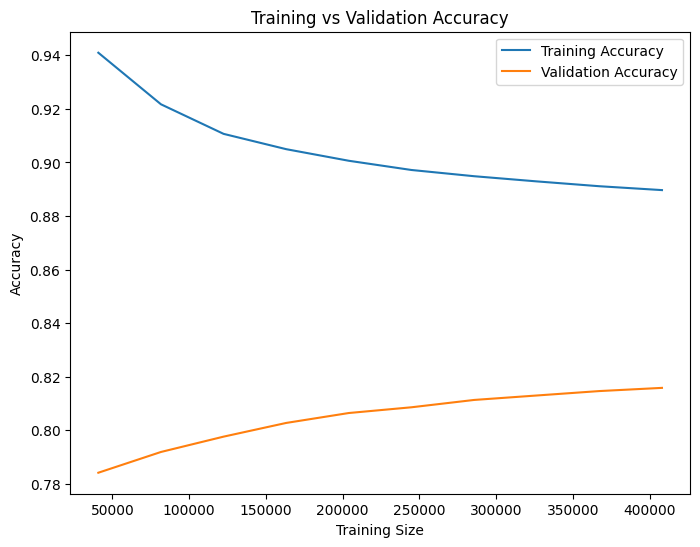

Accuracy: 81.94%


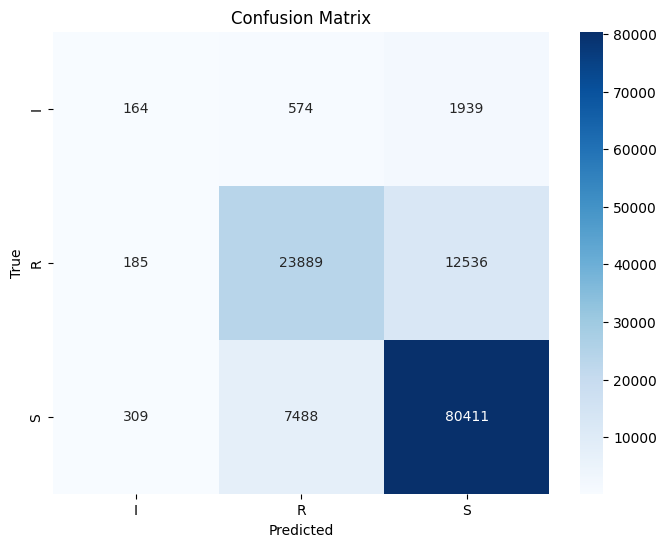

Classification Report:
               precision    recall  f1-score   support

           I       0.25      0.06      0.10      2677
           R       0.75      0.65      0.70     36610
           S       0.85      0.91      0.88     88208

    accuracy                           0.82    127495
   macro avg       0.61      0.54      0.56    127495
weighted avg       0.81      0.82      0.81    127495

Predicted labels sample: ['S' 'S' 'R' 'S' 'R' 'R' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'R' 'S' 'S' 'S' 'S'
 'S' 'S']


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# โหลดข้อมูล
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/File Colab/df_all_raw.csv", low_memory=False)

# Label Encoding สำหรับ categorical features
encoder = LabelEncoder()
df['anti_encoded'] = encoder.fit_transform(df['anti_name_clean'].astype(str))
df['org_encoded'] = encoder.fit_transform(df['org'].astype(str))
df['specimen_encoded'] = encoder.fit_transform(df['specimen_clean'].astype(str))
df['vn_encoded'] = encoder.fit_transform(df['vn'].astype(str))

# Target encoding
y_encoder = LabelEncoder()
df['anti_result_encoded'] = y_encoder.fit_transform(df['anti_result_clean'].astype(str))

# Feature Engineering: date → day_of_week, month
df['date_r'] = pd.to_datetime(df['date_r'], errors='coerce')
df['day_of_week'] = df['date_r'].dt.dayofweek.fillna(0).astype(int)
df['month'] = df['date_r'].dt.month.fillna(0).astype(int)

# Map dia ให้เป็นตัวเลข
dia_map = {"None":0, "Few":1, "Moderate":2, "Many":3}
df['dia'] = df['dia'].map(dia_map).fillna(0).astype(int)

# เติม missing values
df = df.fillna(0)

# Input และ Output
X = df[['anti_encoded','org_encoded','specimen_encoded','vn_encoded','dia','day_of_week','month']]
y = df['anti_result_encoded']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# สร้างโมเดล Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, valid_mean, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Train และ Predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

# ตัวอย่างผลลัพธ์ที่ทำนาย
y_pred_labels = y_encoder.inverse_transform(y_pred)
print("Predicted labels sample:", y_pred_labels[:20])


### 02 Random Forest Classification (df_all_clean)

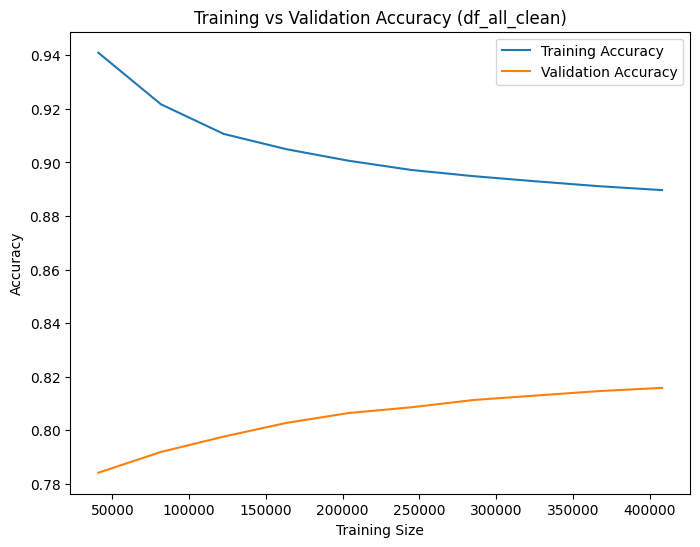

Accuracy (df_all_clean): 81.94%
Classification Report:
               precision    recall  f1-score   support

           I       0.25      0.06      0.10      2677
           R       0.75      0.65      0.70     36610
           S       0.85      0.91      0.88     88208

    accuracy                           0.82    127495
   macro avg       0.61      0.54      0.56    127495
weighted avg       0.81      0.82      0.81    127495



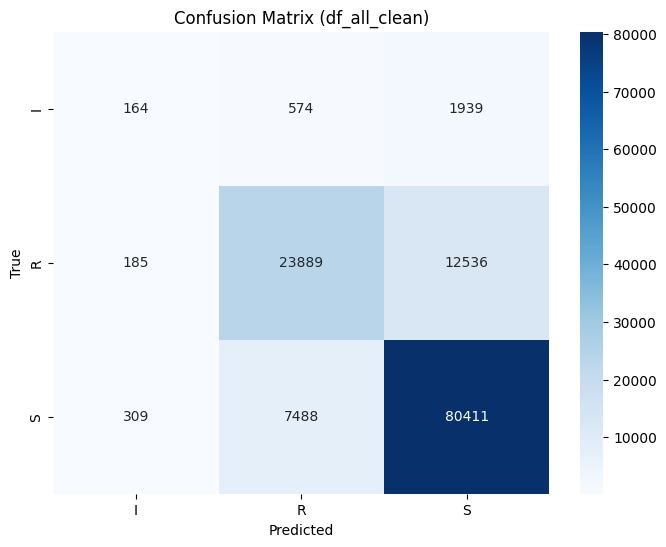

In [ ]:
# ใช้ df_all_clean ที่สร้างไว้จาก Step 3
df_clean = df_all_clean.copy()

# Label Encoding
encoder = LabelEncoder()
df_clean['anti_encoded'] = encoder.fit_transform(df_clean['anti_name_clean'].astype(str))
df_clean['org_encoded'] = encoder.fit_transform(df_clean['org'].astype(str))
df_clean['specimen_encoded'] = encoder.fit_transform(df_clean['specimen_clean'].astype(str))
df_clean['vn_encoded'] = encoder.fit_transform(df_clean['vn'].astype(str))

# Target encoding
y_encoder = LabelEncoder()
df_clean['anti_result_encoded'] = y_encoder.fit_transform(df_clean['anti_result_clean'].astype(str))

# Feature Engineering
df_clean['date_r'] = pd.to_datetime(df_clean['date_r'], errors='coerce')
df_clean['day_of_week'] = df_clean['date_r'].dt.dayofweek.fillna(0).astype(int)
df_clean['month'] = df_clean['date_r'].dt.month.fillna(0).astype(int)

# Map dia
dia_map = {"None":0, "Few":1, "Moderate":2, "Many":3}
df_clean['dia'] = df_clean['dia'].map(dia_map).fillna(0).astype(int)

df_clean = df_clean.fillna(0)

# Input & Output
X = df_clean[['anti_encoded','org_encoded','specimen_encoded','vn_encoded','dia','day_of_week','month']]
y = df_clean['anti_result_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (df_all_clean)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Train & Predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy (df_all_clean): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (df_all_clean)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


###03 Random Forest Classification (df_all_merge)

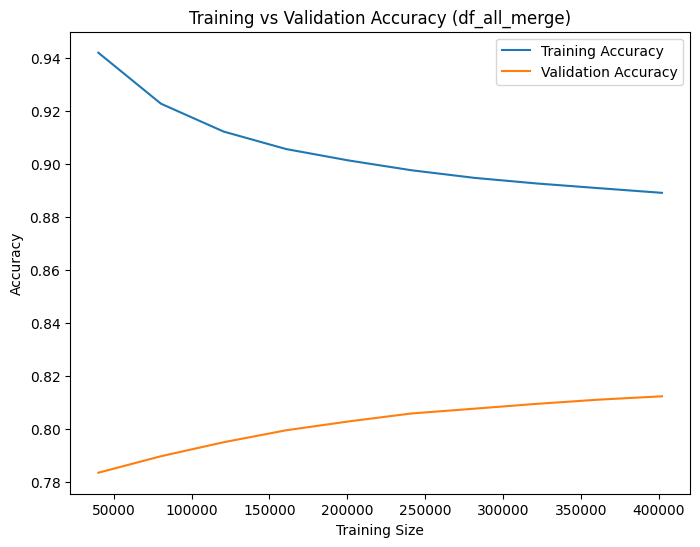

Accuracy (df_all_merge): 81.43%
Classification Report:
               precision    recall  f1-score   support

           I       0.23      0.07      0.10      2649
           R       0.74      0.64      0.69     36094
           S       0.84      0.91      0.87     86877

    accuracy                           0.81    125620
   macro avg       0.61      0.54      0.56    125620
weighted avg       0.80      0.81      0.80    125620



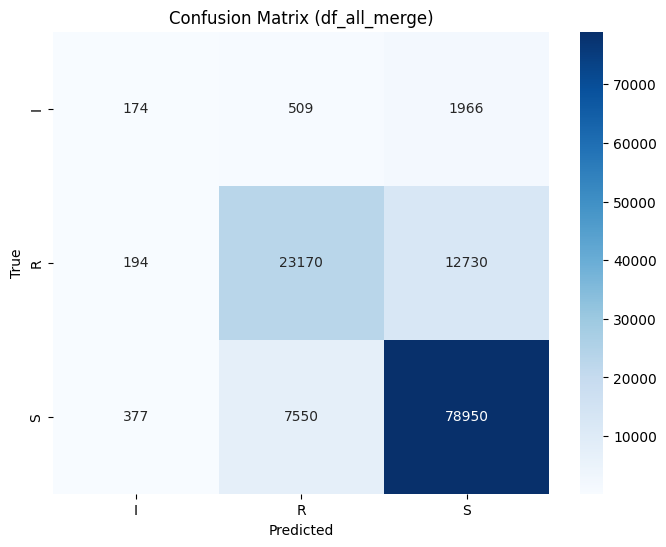

In [ ]:
# STEP 6: Random Forest Classification (df_all_merge)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df_merge = df_all_merge.copy()

# Label Encoding
encoder = LabelEncoder()
df_merge['anti_encoded'] = encoder.fit_transform(df_merge['anti_name_clean'].astype(str))
df_merge['org_encoded'] = encoder.fit_transform(df_merge['org'].astype(str))
df_merge['specimen_encoded'] = encoder.fit_transform(df_merge['specimen_clean'].astype(str))
df_merge['vn_encoded'] = encoder.fit_transform(df_merge['vn'].astype(str))

# Target encoding
y_encoder = LabelEncoder()
df_merge['anti_result_encoded'] = y_encoder.fit_transform(df_merge['anti_result_clean'].astype(str))

# Feature Engineering
df_merge['date_r'] = pd.to_datetime(df_merge['date_r'], errors='coerce')
df_merge['day_of_week'] = df_merge['date_r'].dt.dayofweek.fillna(0).astype(int)
df_merge['month'] = df_merge['date_r'].dt.month.fillna(0).astype(int)

# Map dia
dia_map = {"None":0, "Few":1, "Moderate":2, "Many":3}
df_merge['dia'] = df_merge['dia'].map(dia_map).fillna(0).astype(int)

df_merge = df_merge.fillna(0)

# Input & Output
X = df_merge[['anti_encoded','org_encoded','specimen_encoded','vn_encoded','dia','day_of_week','month']]
y = df_merge['anti_result_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (df_all_merge)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Train & Predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy (df_all_merge): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (df_all_merge)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


###04 Random Forest Classification (df_all_balanced)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


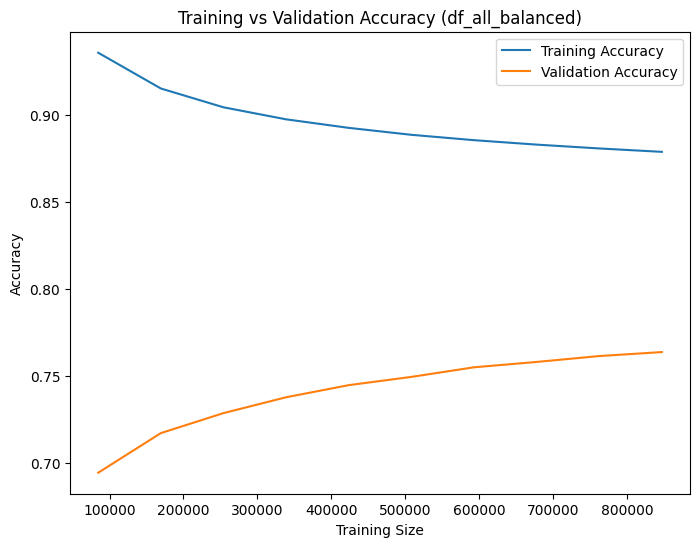

Accuracy (df_all_balanced): 76.79%
Classification Report:
               precision    recall  f1-score   support

           I       0.79      0.80      0.80     88207
           R       0.75      0.69      0.72     88208
           S       0.76      0.81      0.78     88208

    accuracy                           0.77    264623
   macro avg       0.77      0.77      0.77    264623
weighted avg       0.77      0.77      0.77    264623



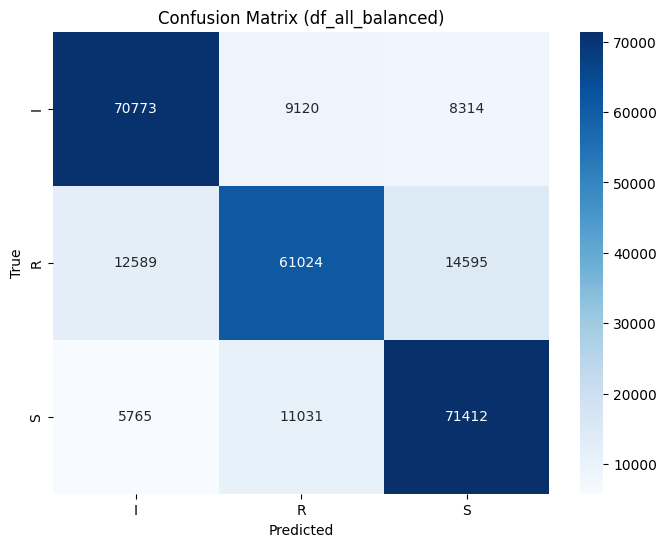

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 6: Random Forest Classification (df_all_balanced)

# Load dataset
df_balanced = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/File Colab/df_all_balanced.csv", low_memory=False)

# Copy for safety
df_merge = df_balanced.copy()

# Label Encoding
encoder = LabelEncoder()
df_merge['anti_encoded'] = encoder.fit_transform(df_merge['anti_name_clean'].astype(str))
df_merge['org_encoded'] = encoder.fit_transform(df_merge['org'].astype(str))
df_merge['specimen_encoded'] = encoder.fit_transform(df_merge['specimen_clean'].astype(str))
df_merge['vn_encoded'] = encoder.fit_transform(df_merge['vn'].astype(str))

# Target encoding
y_encoder = LabelEncoder()
df_merge['anti_result_encoded'] = y_encoder.fit_transform(df_merge['anti_result_clean'].astype(str))

# Feature Engineering
df_merge['date_r'] = pd.to_datetime(df_merge['date_r'], errors='coerce')
df_merge['day_of_week'] = df_merge['date_r'].dt.dayofweek.fillna(0).astype(int)
df_merge['month'] = df_merge['date_r'].dt.month.fillna(0).astype(int)

# Map dia
dia_map = {"None":0, "Few":1, "Moderate":2, "Many":3}
df_merge['dia'] = df_merge['dia'].map(dia_map).fillna(0).astype(int)

# Fill missing values
df_merge = df_merge.fillna(0)

# Input & Output
X = df_merge[['anti_encoded','org_encoded','specimen_encoded','vn_encoded','dia','day_of_week','month']]
y = df_merge['anti_result_encoded']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (df_all_balanced)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Train & Predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy (df_all_balanced): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (df_all_balanced)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


##Logistic Regression

### 01 Logistic Regression (df_all_raw)

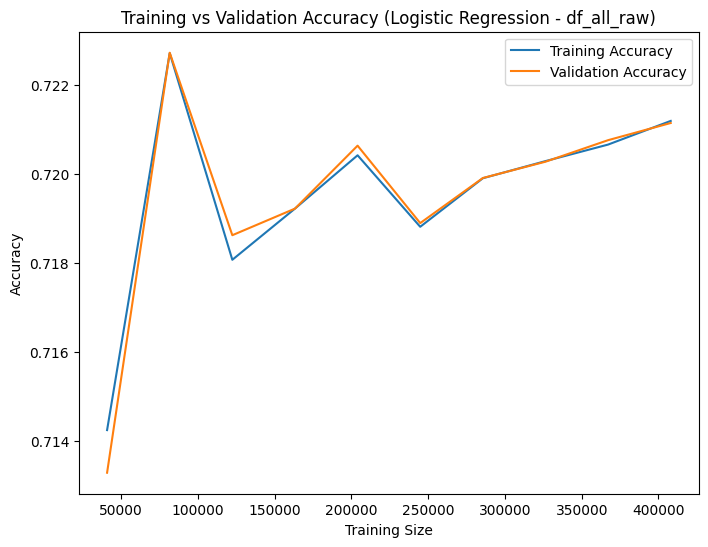

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

Accuracy (Logistic Regression - df_all_raw): 72.06%
Classification Report:
               precision    recall  f1-score   support

           I       0.00      0.00      0.00      2677
           R       0.70      0.17      0.27     36610
           S       0.72      0.97      0.83     88208

    accuracy                           0.72    127495
   macro avg       0.47      0.38      0.37    127495
weighted avg       0.70      0.72      0.65    127495



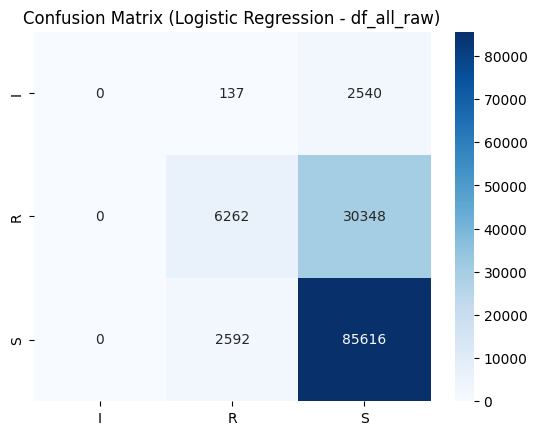

In [ ]:
# STEP 6: Logistic Regression (df_all_raw)


# โหลดข้อมูล
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/File Colab/df_all_raw.csv", low_memory=False)

# Label Encoding
encoder = LabelEncoder()
df['anti_encoded'] = encoder.fit_transform(df['anti_name_clean'].astype(str))
df['org_encoded'] = encoder.fit_transform(df['org'].astype(str))
df['specimen_encoded'] = encoder.fit_transform(df['specimen_clean'].astype(str))
df['vn_encoded'] = encoder.fit_transform(df['vn'].astype(str))

# Target encoding
y_encoder = LabelEncoder()
df['anti_result_encoded'] = y_encoder.fit_transform(df['anti_result_clean'].astype(str))

# Feature Engineering
df['date_r'] = pd.to_datetime(df['date_r'], errors='coerce')
df['day_of_week'] = df['date_r'].dt.dayofweek.fillna(0).astype(int)
df['month'] = df['date_r'].dt.month.fillna(0).astype(int)

# Map dia
dia_map = {"None":0, "Few":1, "Moderate":2, "Many":3}
df['dia'] = df['dia'].map(dia_map).fillna(0).astype(int)

df = df.fillna(0)

X = df[['anti_encoded','org_encoded','specimen_encoded','vn_encoded','dia','day_of_week','month']]
y = df['anti_result_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')

# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Logistic Regression - df_all_raw)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Train & Predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy (Logistic Regression - df_all_raw): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (Logistic Regression - df_all_raw)")
plt.show()


### 02 Logistic Regression (df_all_clean)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

Accuracy (Logistic Regression): 72.18%
Classification Report:
               precision    recall  f1-score   support

           I       0.00      0.00      0.00      2677
           R       0.69      0.18      0.28     36610
           S       0.72      0.97      0.83     88208

    accuracy                           0.72    127495
   macro avg       0.47      0.38      0.37    127495
weighted avg       0.70      0.72      0.66    127495



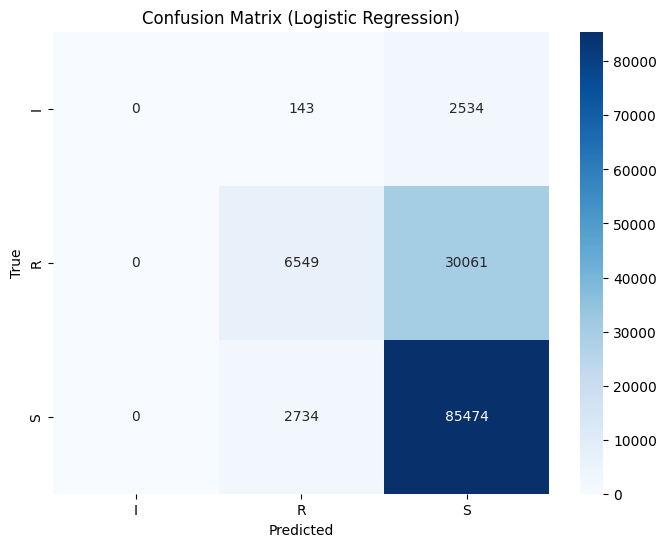

In [ ]:
# STEP 6: Logistic Regression (df_all_clean)

from sklearn.linear_model import LogisticRegression

df_clean = df_all_clean.copy()

# Label Encoding
encoder = LabelEncoder()
df_clean['anti_encoded'] = encoder.fit_transform(df_clean['anti_name_clean'].astype(str))
df_clean['org_encoded'] = encoder.fit_transform(df_clean['org'].astype(str))
df_clean['specimen_encoded'] = encoder.fit_transform(df_clean['specimen_clean'].astype(str))
df_clean['vn_encoded'] = encoder.fit_transform(df_clean['vn'].astype(str))

# Target encoding
y_encoder = LabelEncoder()
df_clean['anti_result_encoded'] = y_encoder.fit_transform(df_clean['anti_result_clean'].astype(str))

# Feature Engineering
df_clean['date_r'] = pd.to_datetime(df_clean['date_r'], errors='coerce')
df_clean['day_of_week'] = df_clean['date_r'].dt.dayofweek.fillna(0).astype(int)
df_clean['month'] = df_clean['date_r'].dt.month.fillna(0).astype(int)

# Map dia
dia_map = {"None":0, "Few":1, "Moderate":2, "Many":3}
df_clean['dia'] = df_clean['dia'].map(dia_map).fillna(0).astype(int)

df_clean = df_clean.fillna(0)

# Input & Output
X = df_clean[['anti_encoded','org_encoded','specimen_encoded','vn_encoded','dia','day_of_week','month']]
y = df_clean['anti_result_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
model = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy (Logistic Regression): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


###03 Logistic Regression (df_all_merge)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

Accuracy (Logistic Regression - df_all_merge): 70.41%
Classification Report:
               precision    recall  f1-score   support

           I       0.00      0.00      0.00      2649
           R       0.63      0.10      0.17     36094
           S       0.71      0.98      0.82     86877

    accuracy                           0.70    125620
   macro avg       0.45      0.36      0.33    125620
weighted avg       0.67      0.70      0.62    125620



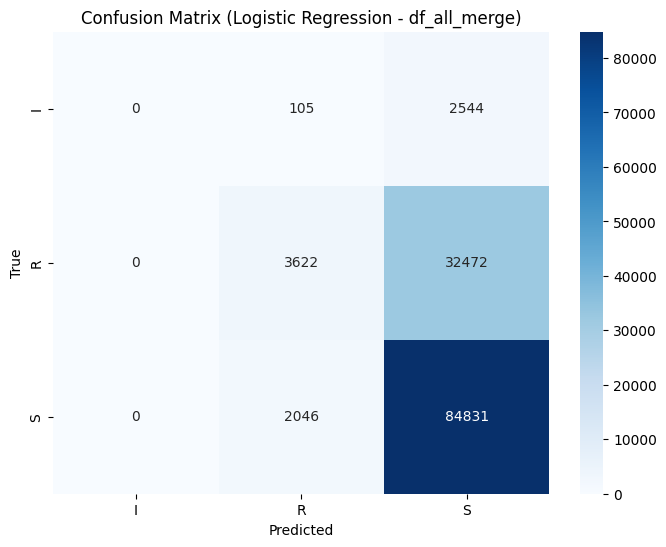

In [ ]:
# STEP 6: Logistic Regression (df_all_merge)
df_merge = df_all_merge.copy()

# Label Encoding
encoder = LabelEncoder()
df_merge['anti_encoded'] = encoder.fit_transform(df_merge['anti_name_clean'].astype(str))
df_merge['org_encoded'] = encoder.fit_transform(df_merge['org'].astype(str))
df_merge['specimen_encoded'] = encoder.fit_transform(df_merge['specimen_clean'].astype(str))
df_merge['vn_encoded'] = encoder.fit_transform(df_merge['vn'].astype(str))

# Target encoding
y_encoder = LabelEncoder()
df_merge['anti_result_encoded'] = y_encoder.fit_transform(df_merge['anti_result_clean'].astype(str))

# Feature Engineering
df_merge['date_r'] = pd.to_datetime(df_merge['date_r'], errors='coerce')
df_merge['day_of_week'] = df_merge['date_r'].dt.dayofweek.fillna(0).astype(int)
df_merge['month'] = df_merge['date_r'].dt.month.fillna(0).astype(int)

# Map dia
dia_map = {"None":0, "Few":1, "Moderate":2, "Many":3}
df_merge['dia'] = df_merge['dia'].map(dia_map).fillna(0).astype(int)

df_merge = df_merge.fillna(0)

# Input & Output
X = df_merge[['anti_encoded','org_encoded','specimen_encoded','vn_encoded','dia','day_of_week','month']]
y = df_merge['anti_result_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
model = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy (Logistic Regression - df_all_merge): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (Logistic Regression - df_all_merge)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


###04 Logistic Regression (df_all_balanced)

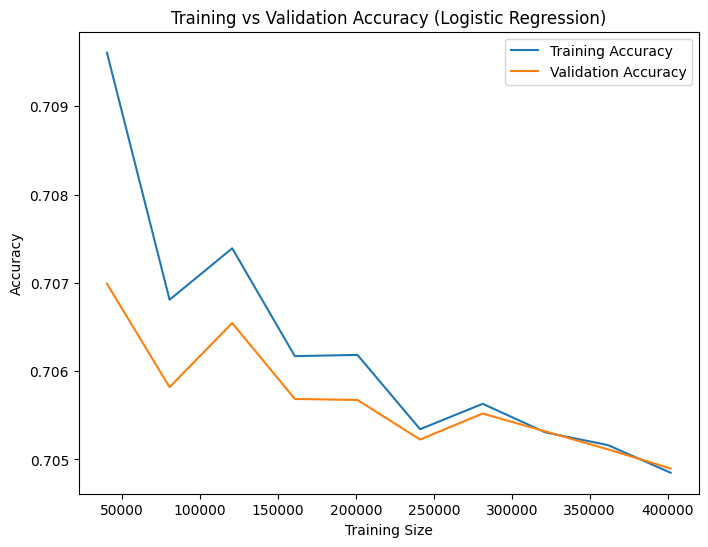

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Accuracy (Logistic Regression): 70.53%
Classification Report:
               precision    recall  f1-score   support

           I       0.00      0.00      0.00      2649
           R       0.63      0.11      0.18     36094
           S       0.71      0.98      0.82     86877

    accuracy                           0.71    125620
   macro avg       0.45      0.36      0.33    125620
weighted avg       0.67      0.71      0.62    125620



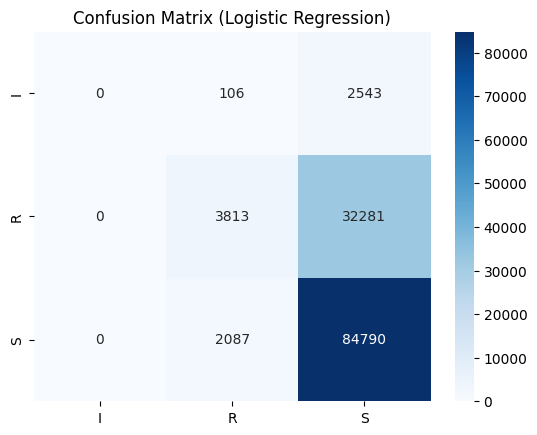

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000, random_state=42)

train_sizes, train_scores, valid_scores = learning_curve(log_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Logistic Regression)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

print(f"Accuracy (Logistic Regression): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


##XGBoost

### 01 XGBoost (df_all_raw)

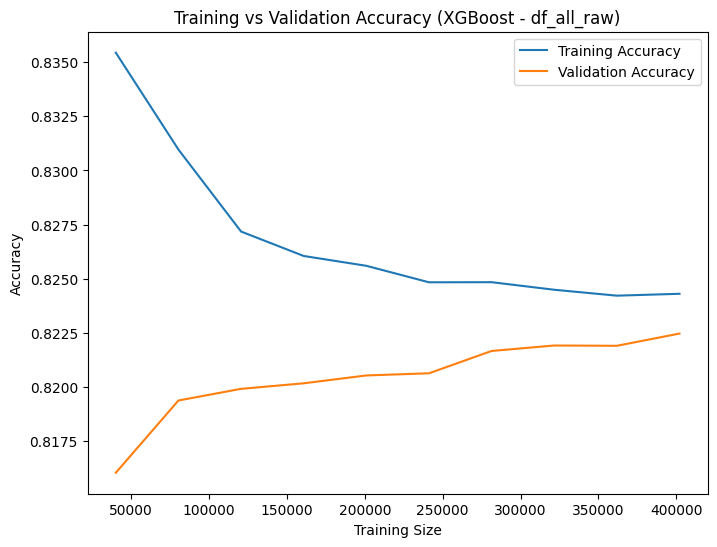

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [09:40:22] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy (XGBoost - df_all_raw): 82.12%
Classification Report:
               precision    recall  f1-score   support

           I       0.48      0.01      0.02      2649
           R       0.77      0.63      0.69     36094
           S       0.84      0.93      0.88     86877

    accuracy                           0.82    125620
   macro avg       0.69      0.52      0.53    125620
weighted avg       0.81      0.82      0.81    125620



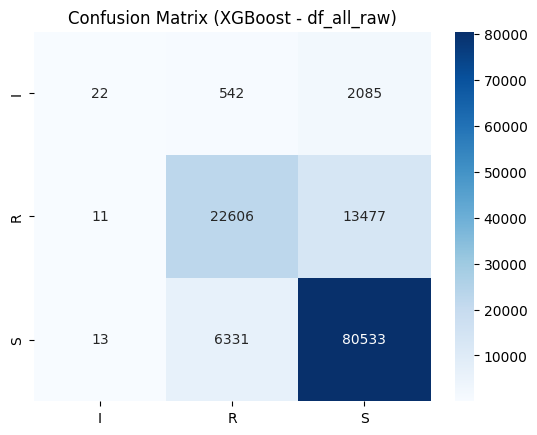

In [ ]:
# STEP 6: XGBoost Classification (df_all_raw)

from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(xgb_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (XGBoost - df_all_raw)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(f"Accuracy (XGBoost - df_all_raw): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (XGBoost - df_all_raw)")
plt.show()


### 02 XGBoost (df_all_clean)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [09:40:58] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy (XGBoost): 82.30%
Classification Report:
               precision    recall  f1-score   support

           I       0.71      0.01      0.02      2677
           R       0.76      0.64      0.69     36610
           S       0.84      0.93      0.88     88208

    accuracy                           0.82    127495
   macro avg       0.77      0.52      0.53    127495
weighted avg       0.82      0.82      0.81    127495



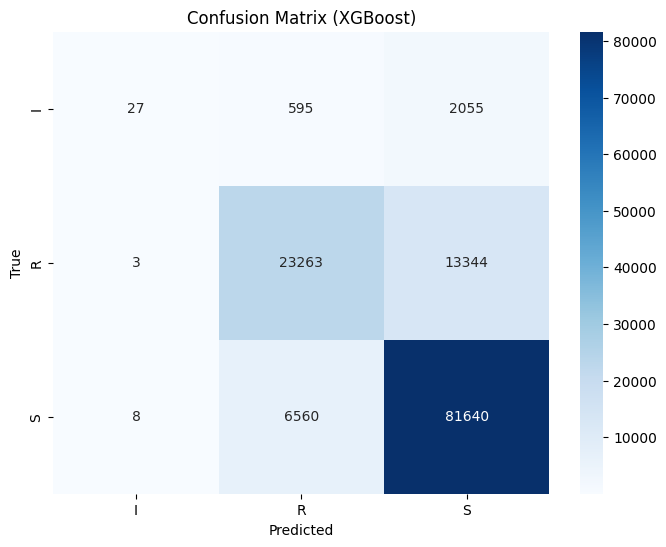

In [ ]:
# XGBoost (df_all_clean)

from xgboost import XGBClassifier

df_clean = df_all_clean.copy()

# Label Encoding
encoder = LabelEncoder()
df_clean['anti_encoded'] = encoder.fit_transform(df_clean['anti_name_clean'].astype(str))
df_clean['org_encoded'] = encoder.fit_transform(df_clean['org'].astype(str))
df_clean['specimen_encoded'] = encoder.fit_transform(df_clean['specimen_clean'].astype(str))
df_clean['vn_encoded'] = encoder.fit_transform(df_clean['vn'].astype(str))

# Target encoding
y_encoder = LabelEncoder()
df_clean['anti_result_encoded'] = y_encoder.fit_transform(df_clean['anti_result_clean'].astype(str))

# Feature Engineering
df_clean['date_r'] = pd.to_datetime(df_clean['date_r'], errors='coerce')
df_clean['day_of_week'] = df_clean['date_r'].dt.dayofweek.fillna(0).astype(int)
df_clean['month'] = df_clean['date_r'].dt.month.fillna(0).astype(int)

# Map dia
dia_map = {"None":0, "Few":1, "Moderate":2, "Many":3}
df_clean['dia'] = df_clean['dia'].map(dia_map).fillna(0).astype(int)

df_clean = df_clean.fillna(0)

# Input & Output
X = df_clean[['anti_encoded','org_encoded','specimen_encoded','vn_encoded','dia','day_of_week','month']]
y = df_clean['anti_result_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy (XGBoost): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### 03 XGBoost (df_all_merge)

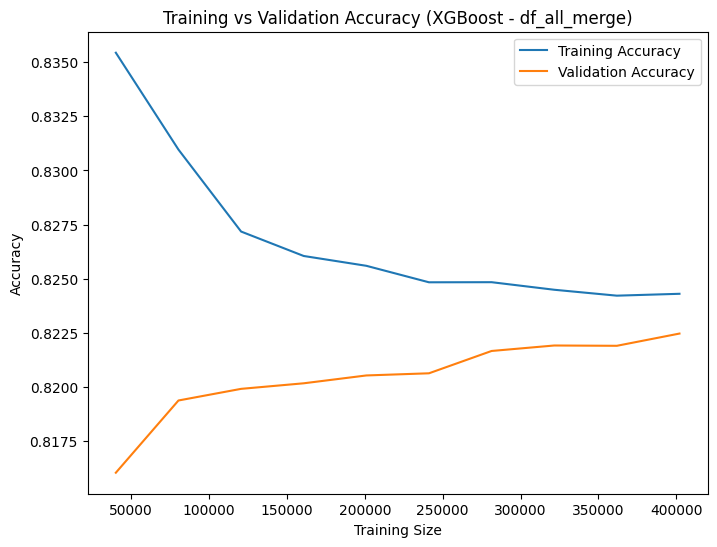

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [09:54:42] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy (XGBoost - df_all_merge): 82.12%
Classification Report:
               precision    recall  f1-score   support

           I       0.48      0.01      0.02      2649
           R       0.77      0.63      0.69     36094
           S       0.84      0.93      0.88     86877

    accuracy                           0.82    125620
   macro avg       0.69      0.52      0.53    125620
weighted avg       0.81      0.82      0.81    125620



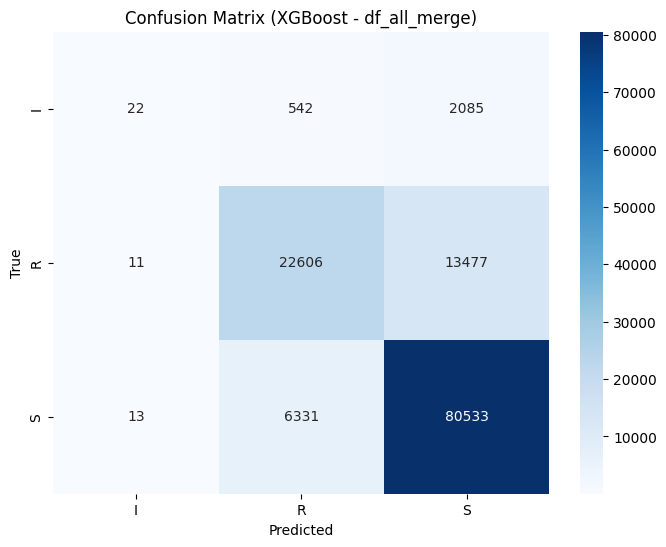

In [ ]:
# STEP 6: XGBoost Classification (df_all_merge)
# เตรียมข้อมูล
df_merge = df_all_merge.copy()

encoder = LabelEncoder()
df_merge['anti_encoded'] = encoder.fit_transform(df_merge['anti_name_clean'].astype(str))
df_merge['org_encoded'] = encoder.fit_transform(df_merge['org'].astype(str))
df_merge['specimen_encoded'] = encoder.fit_transform(df_merge['specimen_clean'].astype(str))
df_merge['vn_encoded'] = encoder.fit_transform(df_merge['vn'].astype(str))

y_encoder = LabelEncoder()
df_merge['anti_result_encoded'] = y_encoder.fit_transform(df_merge['anti_result_clean'].astype(str))

df_merge['date_r'] = pd.to_datetime(df_merge['date_r'], errors='coerce')
df_merge['day_of_week'] = df_merge['date_r'].dt.dayofweek.fillna(0).astype(int)
df_merge['month'] = df_merge['date_r'].dt.month.fillna(0).astype(int)

dia_map = {"None":0, "Few":1, "Moderate":2, "Many":3}
df_merge['dia'] = df_merge['dia'].map(dia_map).fillna(0).astype(int)

df_merge = df_merge.fillna(0)

X = df_merge[['anti_encoded','org_encoded','specimen_encoded','vn_encoded','dia','day_of_week','month']]
y = df_merge['anti_result_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost Model
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (XGBoost - df_all_merge)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Train & Predict
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(f"Accuracy (XGBoost - df_all_merge): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (XGBoost - df_all_merge)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### 04 XGBoost (df_all_balanced)

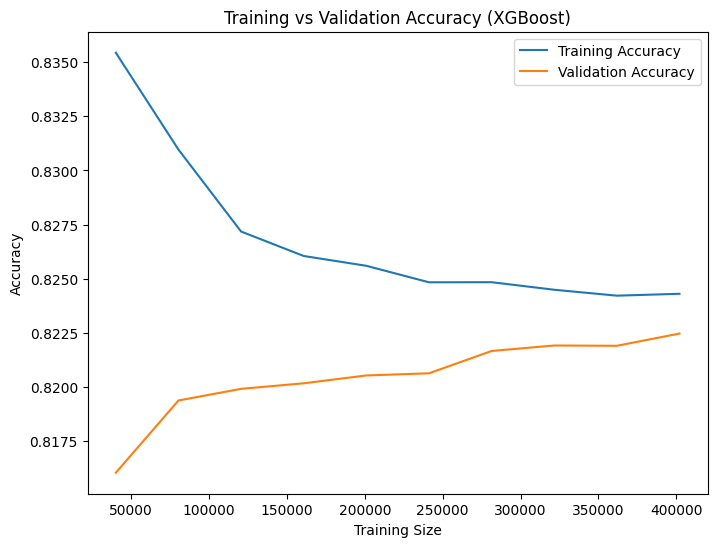

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [10:08:24] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy (XGBoost): 82.12%
Classification Report:
               precision    recall  f1-score   support

           I       0.48      0.01      0.02      2649
           R       0.77      0.63      0.69     36094
           S       0.84      0.93      0.88     86877

    accuracy                           0.82    125620
   macro avg       0.69      0.52      0.53    125620
weighted avg       0.81      0.82      0.81    125620



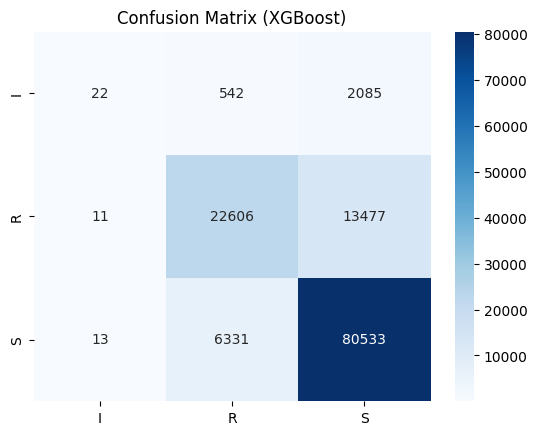

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

train_sizes, train_scores, valid_scores = learning_curve(xgb_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (XGBoost)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(f"Accuracy (XGBoost): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (XGBoost)")
plt.show()


##Neural Network (MLPClassifier)

### 01 Neural Network (df_all_raw)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6978 - loss: 0.6932 - val_accuracy: 0.7177 - val_loss: 0.6470
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7145 - loss: 0.6518 - val_accuracy: 0.7218 - val_loss: 0.6344
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7170 - loss: 0.6385 - val_accuracy: 0.7225 - val_loss: 0.6234
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7222 - loss: 0.6270 - val_accuracy: 0.7259 - val_loss: 0.6114
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7240 - loss: 0.6184 - val_accuracy: 0.7247 - val_loss: 0.6006
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7279 - loss: 0.6076 - val_accuracy: 0.7310 - val_loss: 0.5915
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7310 - loss: 0.6006 - val_accuracy: 0.7419 - val_loss: 0.5851
Epoch 8/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7347 - loss: 0.5964 - 

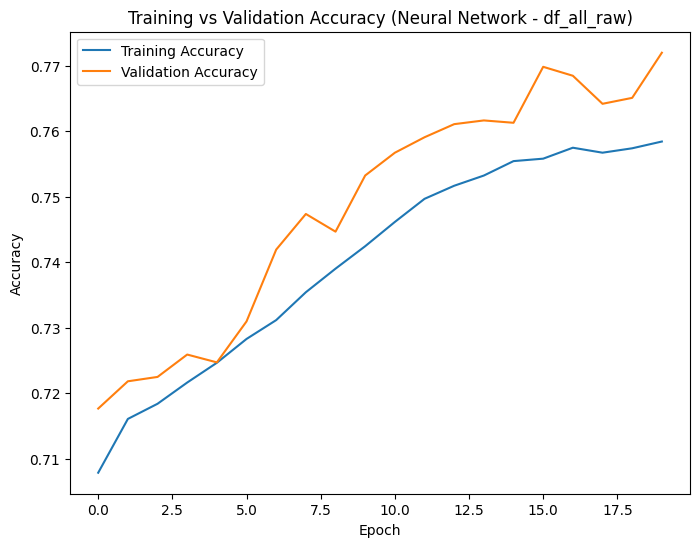

Accuracy (Neural Network - df_all_raw): 77.34%
3926/3926 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           I       0.00      0.00      0.00      2649
           R       0.69      0.49      0.57     36094
           S       0.79      0.92      0.85     86877

    accuracy                           0.77    125620
   macro avg       0.50      0.47      0.47    125620
weighted avg       0.75      0.77      0.75    125620



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


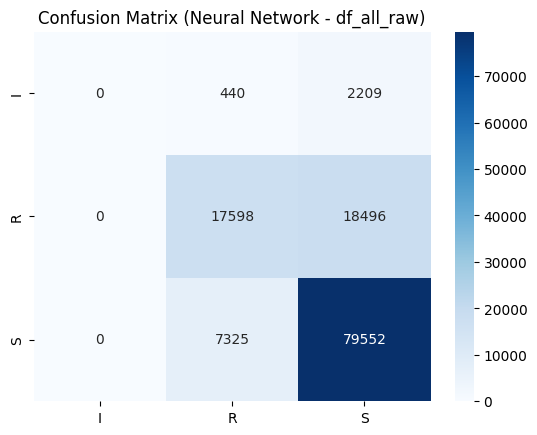

In [ ]:
# STEP 6: Neural Network Classification (df_all_raw)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=len(y_encoder.classes_))
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=len(y_encoder.classes_))

nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(y_encoder.classes_), activation='softmax')
])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Curve (Epoch-based)
history = nn_model.fit(X_train, y_train_cat, epochs=20, batch_size=256, validation_split=0.2, verbose=1)

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Neural Network - df_all_raw)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

loss, acc = nn_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Accuracy (Neural Network - df_all_raw): {acc*100:.2f}%")

y_pred_nn = nn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_nn, axis=1)

print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=y_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (Neural Network - df_all_raw)")
plt.show()


### 02 Neural Network (df_all_clean)

Accuracy (Neural Network): 72.53%
Classification Report:
               precision    recall  f1-score   support

           I       0.00      0.00      0.00      2677
           R       0.72      0.18      0.29     36610
           S       0.73      0.97      0.83     88208

    accuracy                           0.73    127495
   macro avg       0.48      0.39      0.37    127495
weighted avg       0.71      0.73      0.66    127495



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


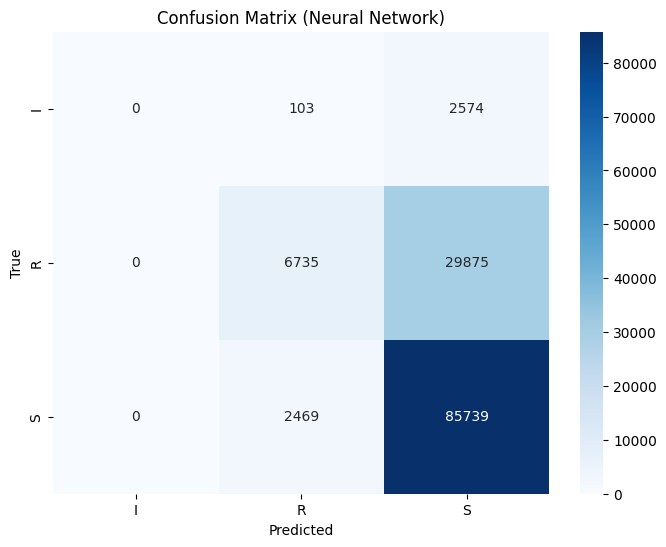

In [ ]:
# Neural Network (MLPClassifier) (df_all_clean)

from sklearn.neural_network import MLPClassifier

df_clean = df_all_clean.copy()

# Label Encoding
encoder = LabelEncoder()
df_clean['anti_encoded'] = encoder.fit_transform(df_clean['anti_name_clean'].astype(str))
df_clean['org_encoded'] = encoder.fit_transform(df_clean['org'].astype(str))
df_clean['specimen_encoded'] = encoder.fit_transform(df_clean['specimen_clean'].astype(str))
df_clean['vn_encoded'] = encoder.fit_transform(df_clean['vn'].astype(str))

# Target encoding
y_encoder = LabelEncoder()
df_clean['anti_result_encoded'] = y_encoder.fit_transform(df_clean['anti_result_clean'].astype(str))

# Feature Engineering
df_clean['date_r'] = pd.to_datetime(df_clean['date_r'], errors='coerce')
df_clean['day_of_week'] = df_clean['date_r'].dt.dayofweek.fillna(0).astype(int)
df_clean['month'] = df_clean['date_r'].dt.month.fillna(0).astype(int)

# Map dia
dia_map = {"None":0, "Few":1, "Moderate":2, "Many":3}
df_clean['dia'] = df_clean['dia'].map(dia_map).fillna(0).astype(int)

df_clean = df_clean.fillna(0)

# Input & Output
X = df_clean[['anti_encoded','org_encoded','specimen_encoded','vn_encoded','dia','day_of_week','month']]
y = df_clean['anti_result_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Neural Network (MLPClassifier)
model = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy (Neural Network): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (Neural Network)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### 03 Neural Network Classification (df_all_merge)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6943 - loss: 0.6967 - val_accuracy: 0.7186 - val_loss: 0.6472
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7156 - loss: 0.6483 - val_accuracy: 0.7203 - val_loss: 0.6348
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7181 - loss: 0.6379 - val_accuracy: 0.7206 - val_loss: 0.6240
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7217 - loss: 0.6267 - val_accuracy: 0.7231 - val_loss: 0.6143
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7238 - loss: 0.6208 - val_accuracy: 0.7299 - val_loss: 0.6033
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7279 - loss: 0.6122 - val_accuracy: 0.7371 - val_loss: 0.5957
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7311 - loss: 0.6040 - val_accuracy: 0.7411 - val_loss: 0.5894
Epoch 8/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7350 - loss: 0.5990 - val_accura

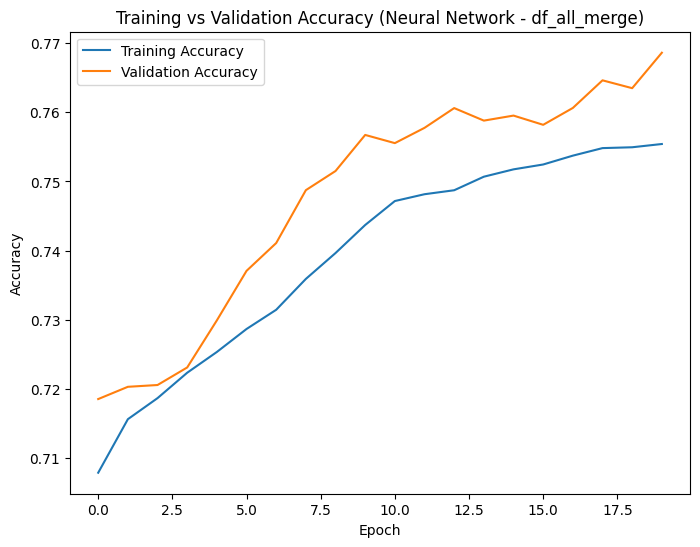

Accuracy (Neural Network - df_all_merge): 76.84%
3926/3926 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           I       0.00      0.00      0.00      2649
           R       0.67      0.50      0.57     36094
           S       0.80      0.90      0.85     86877

    accuracy                           0.77    125620
   macro avg       0.49      0.47      0.47    125620
weighted avg       0.74      0.77      0.75    125620



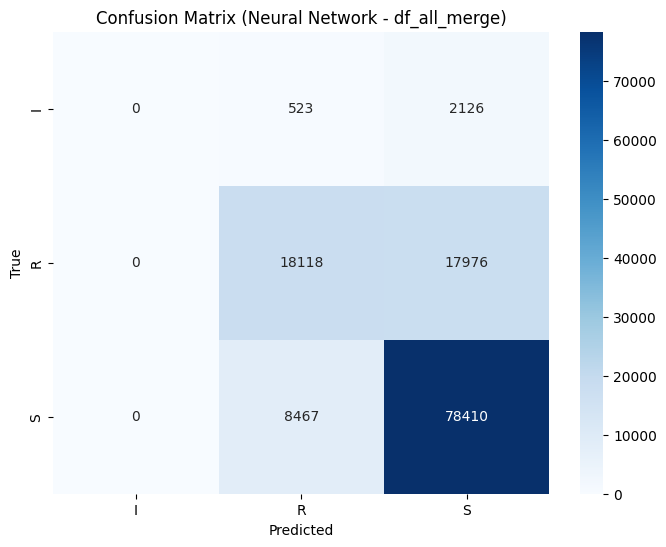

In [ ]:
# STEP 6: Neural Network Classification (df_all_merge)
df_merge = df_all_merge.copy()

encoder = LabelEncoder()
df_merge['anti_encoded'] = encoder.fit_transform(df_merge['anti_name_clean'].astype(str))
df_merge['org_encoded'] = encoder.fit_transform(df_merge['org'].astype(str))
df_merge['specimen_encoded'] = encoder.fit_transform(df_merge['specimen_clean'].astype(str))
df_merge['vn_encoded'] = encoder.fit_transform(df_merge['vn'].astype(str))

y_encoder = LabelEncoder()
df_merge['anti_result_encoded'] = y_encoder.fit_transform(df_merge['anti_result_clean'].astype(str))

df_merge['date_r'] = pd.to_datetime(df_merge['date_r'], errors='coerce')
df_merge['day_of_week'] = df_merge['date_r'].dt.dayofweek.fillna(0).astype(int)
df_merge['month'] = df_merge['date_r'].dt.month.fillna(0).astype(int)

dia_map = {"None":0, "Few":1, "Moderate":2, "Many":3}
df_merge['dia'] = df_merge['dia'].map(dia_map).fillna(0).astype(int)

df_merge = df_merge.fillna(0)

X = df_merge[['anti_encoded','org_encoded','specimen_encoded','vn_encoded','dia','day_of_week','month']]
y = df_merge['anti_result_encoded']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# One-hot encode target
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=len(y_encoder.classes_))
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=len(y_encoder.classes_))

# Neural Network Model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(y_encoder.classes_), activation='softmax')
])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Curve (Epoch-based)
history = nn_model.fit(X_train, y_train_cat, epochs=20, batch_size=256, validation_split=0.2, verbose=1)

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Neural Network - df_all_merge)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Evaluate
loss, acc = nn_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Accuracy (Neural Network - df_all_merge): {acc*100:.2f}%")

# Predict
y_pred_nn = nn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_nn, axis=1)

print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=y_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (Neural Network - df_all_merge)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### 04  Neural Network (df_all_balanced)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6955 - loss: 0.6930 - val_accuracy: 0.7182 - val_loss: 0.6480
Epoch 2/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7150 - loss: 0.6506 - val_accuracy: 0.7216 - val_loss: 0.6359
Epoch 3/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7178 - loss: 0.6404 - val_accuracy: 0.7219 - val_loss: 0.6246
Epoch 4/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7213 - loss: 0.6302 - val_accuracy: 0.7251 - val_loss: 0.6126
Epoch 5/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7241 - loss: 0.6195 - val_accuracy: 0.7291 - val_loss: 0.6025
Epoch 6/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7270 - loss: 0.6111 - val_accuracy: 0.7355 - val_loss: 0.5943
Epoch 7/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7319 - loss: 0.6047 - val_accuracy: 0.7415 - val_loss: 0.5906
Epoch 8/20
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7342 - loss: 0.5993 - val_accura

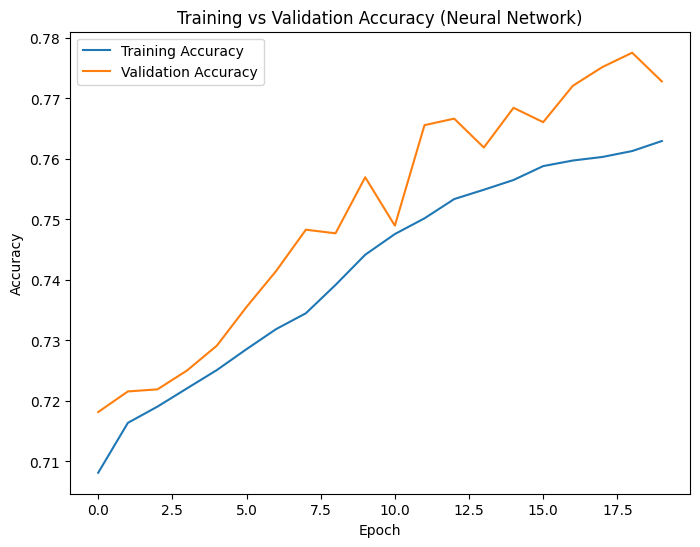

Accuracy (Neural Network): 77.15%
3926/3926 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           I       0.00      0.00      0.00      2649
           R       0.73      0.43      0.54     36094
           S       0.78      0.94      0.85     86877

    accuracy                           0.77    125620
   macro avg       0.50      0.46      0.46    125620
weighted avg       0.75      0.77      0.74    125620



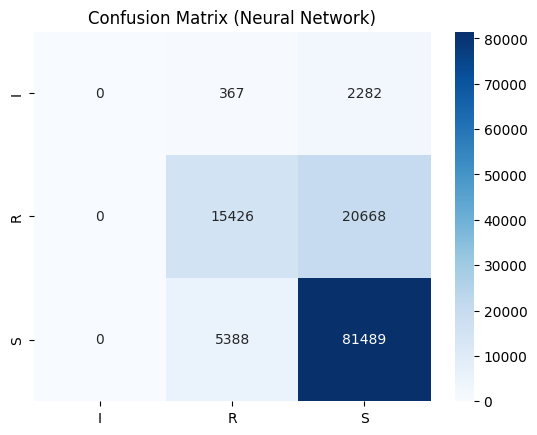

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=len(y_encoder.classes_))
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=len(y_encoder.classes_))

nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(y_encoder.classes_), activation='softmax')
])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = nn_model.fit(X_train, y_train_cat, epochs=20, batch_size=256, validation_split=0.2, verbose=1)

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Neural Network)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

loss, acc = nn_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Accuracy (Neural Network): {acc*100:.2f}%")

y_pred_nn = nn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_nn, axis=1)

print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=y_encoder.classes_))

sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Confusion Matrix (Neural Network)")
plt.show()
